In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from pathlib import Path
from contextlib import contextmanager


In [ ]:
def download_all_plot_data(
    layers=(0, 5, 11),
    categories=None,
    sweep_ids=None,
):
    """Download and cache all data needed for plotting.

    This hits W&B once to pull:
    - Attention entropy metrics for each (category, layer) pair.
    - Train/val loss by optimizer variant for the configured sweeps.
    - Train/loss per learning rate for each attention category's sweeps.

    Results are saved under plotting/cache/ as pickled DataFrames, and
    subsequent plotting calls (plot_all_layers, plot_all_variants_from_sweeps,
    plot_train_loss_for_attn_category) will load from these caches instead of
    re-querying W&B.
    """
    if categories is None:
        try:
            categories = ATTN_CATEGORIES
        except NameError as exc:
            raise NameError(
                "ATTN_CATEGORIES is not defined. Run the constants/mappings cell before calling download_all_plot_data()."
            ) from exc
    if sweep_ids is None:
        try:
            sweep_ids = VARIANT_SWEEP_IDS
        except NameError:
            sweep_ids = None
    PLOTTING_CACHE_DIR.mkdir(parents=True, exist_ok=True)

    # Attention entropy caches
    # for category_name, ids in categories.items():
    #     for layer in layers:
    #         print(f"[download] attn entropy for {category_name}, layer {layer}...")
    #         df = get_attn_entropy_for_ids(ids, layer)
    #         if df.empty:
    #             print("  (no data)")
    #             continue
    #         path = _attn_cache_path(category_name, layer)
    #         df.to_pickle(path)
    #         print(f"  saved to {path}")

    # Variant loss caches (optimizer variants sweep)
    for metric_key in ("train/loss", "val/loss"):
        print(f"[download] {metric_key} for optimizer variants...")
        df = get_loss_by_variant(metric_key, sweep_ids=sweep_ids)
        if df.empty:
            print("  (no data)")
            continue
        path = _variant_cache_path(metric_key, sweep_ids)
        df.to_pickle(path)
        print(f"  saved to {path}")

    # Train loss caches for attention categories (per LR)
    for category_name, ids in categories.items():
        print(f"[download] train/loss for {category_name} (attn sweeps)...")
        df = get_train_loss_for_attn_category(category_name, ids=ids)
        if df.empty:
            print("  (no data)")
            continue
        path = _train_loss_cache_path_for_category(category_name)
        df.to_pickle(path)
        print(f"  saved to {path}")

    print("Done. Future plotting calls will use cached data unless use_cache=False.")

In [7]:
ENTITY = "justin_yang-university-of-california-berkeley"
PROJECT = "cs182-project-GPT-opt"

# Local cache directory for plotting data (ignored by git)
PLOTTING_CACHE_DIR = Path("plotting") / "cache"
PLOTTING_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Map high-level optimizer categories to sweep IDs or run IDs.
ATTN_CATEGORIES = {
    "AdamW": ["pxrm9xt8", "hkw05gba", "eifb7cyl", "4uytpec5"],
    "Muon-NS-All": ["qmzevjll", "lh2tzeh1", "capygls4"],
    "Muon-NS-VOFFN": ["88vr9lps"],
    "Muon-PE-All": ["emzbw2qc", "q02rln6i"],
    "Muon-PE-VOFFN": ["67g7mm51"],
}

# Nicer titles for figure headers
ATTN_CATEGORY_TITLES = {
    "AdamW": "AdamW",
    "Muon-NS-All": "Muon Newton-Schulz (QKV, O, FFN)",
    "Muon-NS-VOFFN": "Muon Newton-Schulz (V, O, FFN)",
    "Muon-PE-All": "Muon Polar Express (QKV, O, FFN)",
    "Muon-PE-VOFFN": "Muon Polar Express (V, O, FFN)",
}

# Fixed y-axis range for all attention entropy plots
DEFAULT_YLIM = (0.0, 6.0)

# Use epoch fraction on x-axis instead of raw step
USE_EPOCH_X = True
EPOCH_MAX = 0.3  # runs are 0.3 epochs


def _collect_runs_for_ids(ids, entity=ENTITY, project=PROJECT):
    """Given a list of sweep IDs and/or run IDs, return a flat list of runs."""
    api = wandb.Api()
    runs = []
    for _id in ids:
        # Try treating as a sweep ID first
        try:
            sweep = api.sweep(f"{entity}/{project}/{_id}")
            runs.extend(list(sweep.runs))
            continue
        except Exception:
            pass
        # Fallback: single run ID
        try:
            run = api.run(f"{entity}/{project}/{_id}")
            runs.append(run)
        except Exception as e:
            print(f"Warning: could not load sweep or run '{_id}': {e}")
    return runs


def _attn_cache_path(category_name, layer):
    safe_cat = str(category_name).replace("/", "_")
    return PLOTTING_CACHE_DIR / f"attn_{safe_cat}_layer{layer}.pkl"


def _load_attn_cache(category_name, layer):
    path = _attn_cache_path(category_name, layer)
    if path.exists():
        try:
            return pd.read_pickle(path)
        except Exception as e:
            print(f"Warning: failed to read attention cache {path}: {e}")
    return None


def _save_attn_cache(category_name, layer, df):
    path = _attn_cache_path(category_name, layer)
    try:
        df.to_pickle(path)
    except Exception as e:
        print(f"Warning: failed to write attention cache {path}: {e}")


def get_attn_entropy_for_ids(ids, layer, entity=ENTITY, project=PROJECT):
    """Aggregate attn/layer{layer}/entropy/mean across runs.

    Returns a DataFrame with columns: lr, step, mean, std, sem, n.
    """
    metric_key = f"attn/layer{layer}/entropy/mean"
    runs = _collect_runs_for_ids(ids, entity=entity, project=project)
    records = []

    for run in runs:
        # Try nested sweep config, then flat key
        lr = None
        try:
            lr = run.config["optimizer_params"]["args"]["lr"]
        except Exception:
            lr = run.config.get("optimizer_params.args.lr", None)
        if lr is None:
            continue

        for row in run.scan_history():
            if metric_key not in row:
                continue
            val = row[metric_key]
            step = row.get("_step", None)
            if step is None or val is None:
                continue
            records.append(
                {
                    "lr": float(lr),
                    "step": int(step),
                    "value": float(val),
                    "run_id": run.id,
                }
            )

    if not records:
        return pd.DataFrame(columns=["lr", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["lr", "step"])["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["lr", "step"])
    return grouped


def plot_attn_entropy_category(
    category_name,
    ids,
    layer,
    ax=None,
    ylim=DEFAULT_YLIM,
    add_legend=True,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    print_end_stats=True,
):
    """Plot mean line + SEM band for a category (set of sweeps/runs) for one layer.

    If use_cache is True (default), try to read a cached DataFrame for this
    (category, layer) combination from disk; if missing, download from W&B
    once, cache it, and then plot.

    lr_min / lr_max: if provided, restrict curves to learning rates within
    [lr_min, lr_max].

    print_end_stats: if True, print for each learning rate the final mean and
    (mean ± SEM) at the last logged step.
    """
    df = _load_attn_cache(category_name, layer) if use_cache else None
    if df is None:
        df = get_attn_entropy_for_ids(ids, layer)
        if use_cache and not df.empty:
            _save_attn_cache(category_name, layer, df)

    # For AdamW, drop very large learning rates to focus on the main range
    if category_name == "AdamW" and not df.empty:
        df = df[df["lr"] <= 0.0024 + 1e-12]

    # Optional LR filtering
    if lr_min is not None:
        df = df[df["lr"] >= lr_min]
    if lr_max is not None:
        df = df[df["lr"] <= lr_max]

    if df.empty:
        print(f"No data found for {category_name}, layer {layer} after LR filtering.")
        return

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    sns.set_style("whitegrid")

    # Normalize steps so that the earliest diagnostic log maps to epoch 0
    min_step = df["step"].min() if not df.empty else 0
    max_step = df["step"].max() if not df.empty else 0
    span = max(max_step - min_step, 1)

    for lr, sub in df.groupby("lr"):
        sub = sub.sort_values("step")
        steps = sub["step"].values.astype(float)
        mean_vals = sub["mean"].values
        sem_vals = sub["sem"].fillna(0.0).values

        if use_epoch_x:
            x_vals = (steps - min_step) / span * (epoch_max if epoch_max is not None else 1.0)
        else:
            x_vals = steps

        ax.plot(x_vals, mean_vals, label=f"{lr:g}")
        ax.fill_between(x_vals, mean_vals - sem_vals, mean_vals + sem_vals, alpha=0.25)

        # Optionally print final mean and error-bar bounds for this learning rate
        if print_end_stats and len(mean_vals) > 0:
            final_mean = float(mean_vals[-1])
            final_sem = float(sem_vals[-1])
            lower = final_mean - final_sem
            upper = final_mean + final_sem
            print(
                f"{category_name}, layer {layer}, lr={lr:g}: "
                f"final mean={final_mean:.4f}, lower={lower:.4f}, upper={upper:.4f}"
            )

    title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)
    ax.set_title(f"Layer {layer} Attention Entropy for {title_base}", pad=14)
    ax.set_ylabel("Mean Entropy")
    if ylim is not None:
        ax.set_ylim(*ylim)

    # X-axis labeling
    if use_epoch_x:
        ax.set_xlabel("Epoch")
        if epoch_max is not None:
            ax.set_xlim(0.0, epoch_max)
    else:
        ax.set_xlabel("Step")
        ax.set_xlim(left=0.0)

    # Ensure y-axis tick labels are visible on all subplots
    ax.tick_params(axis="y", labelleft=True)

    if add_legend:
        ax.legend(title="Learning Rate", fontsize=8)

    return ax


def plot_layers_for_category(
    category_name,
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    print_end_stats=True,
):
    """For a single category, make one figure with subplots (3 in a row by default)."""
    ids = categories[category_name]
    n_layers = len(layers)
    fig, axes = plt.subplots(1, n_layers, figsize=(5 * n_layers, 4), sharey=True)
    if n_layers == 1:
        axes = [axes]

    # First axis gets a legend so we can harvest handles/labels
    for i, (ax, layer) in enumerate(zip(axes, layers)):
        add_legend = (i == 0)
        plot_attn_entropy_category(
            category_name,
            ids,
            layer,
            ax=ax,
            ylim=ylim,
            add_legend=add_legend,
            use_epoch_x=use_epoch_x,
            epoch_max=epoch_max,
            use_cache=use_cache,
            lr_min=lr_min,
            lr_max=lr_max,
            print_end_stats=print_end_stats,
        )

    # Build a single shared legend from the first axis, then remove per-axis legend
    handles, labels = axes[0].get_legend_handles_labels()
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()

    fig.legend(
        handles,
        labels,
        title="Learning Rate",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08),
        ncol=min(4, len(labels)),
        fontsize=8,
    )
    fig.suptitle(ATTN_CATEGORY_TITLES.get(category_name, category_name), y=1.16)
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

    return fig, axes


def plot_all_layers(
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    print_end_stats=True,
):
    """For each category, produce one figure with |layers| subplots (side by side)."""
    for name in categories.keys():
        plot_layers_for_category(
            name,
            layers=layers,
            categories=categories,
            ylim=ylim,
            use_epoch_x=use_epoch_x,
            epoch_max=epoch_max,
            use_cache=use_cache,
            lr_min=lr_min,
            lr_max=lr_max,
            print_end_stats=print_end_stats,
        )

In [8]:
# ---- Layout knobs for combined attention figure ----
# You can tweak these values and re-run this cell if titles/legends
# look slightly misaligned in your environment.
COMBINED_LEGEND_Y = 1.08     # vertical anchor for LR legend (relative to top axis)
COMBINED_SUBTITLE_Y = 0.81   # y-position for optimizer names (figure coords)
COMBINED_TITLE_Y = 0.87      # y-position for main title (figure coords)
COMBINED_TIGHT_RECT = (0, 0, 1, 0.86)  # reserved top band for titles/legends

# Optional small horizontal nudges for each optimizer subtitle (figure coords).
# Positive values move the label to the right, negative to the left.
# Typical magnitudes are around +/- 0.005 or 0.01.
COMBINED_SUBTITLE_X_NUDGE = {
    "AdamW": -0.07,
    "Muon-NS-All": -0.03,
    "Muon-PE-All": 0,
    "Muon-NS-VOFFN": 0.03,
    "Muon-PE-VOFFN": 0.07,
}


def plot_all_categories_combined(
    categories_order=("AdamW", "Muon-NS-All", "Muon-PE-All", "Muon-NS-VOFFN", "Muon-PE-VOFFN"),
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    # Global LR filters (fallback/default)
    lr_min=None,
    lr_max=None,
    # Optional per-category LR ranges: {"AdamW": (min, max), ...}
    lr_ranges_by_category=None,
    # Kept for API compatibility; currently unused in this variant.
    base_lr_by_category=None,
    print_end_stats=False,
):
    """Make a single combined figure of attention entropy across all categories.

    Layout: rows = layers (e.g., 0, 5, 11), columns = optimizer categories
    (AdamW, Muon-NS-All, Muon-PE-All, Muon-NS-VOFFN, Muon-PE-VOFFN).

    Each axis is produced by `plot_attn_entropy_category`, but we:
    - share x/y axes across the grid,
    - place a *legend with raw LR values* just above each optimizer column
      (attached to the top-row subplot for that column, but outside the
       plotting area),
    - render the optimizer name as a subtitle above the LR legend, and
    - clean up per-axis labels so the result is paper-friendly.

    If the placement of legends/titles looks off, edit the COMBINED_*
    knobs at the top of this cell (including COMBINED_SUBTITLE_X_NUDGE)
    and re-run it.

    LR filtering behavior:
    - If `lr_ranges_by_category` is provided and contains an entry for a
      category, that (min, max) is used for that category.
    - Otherwise, the global `lr_min` / `lr_max` values are used.
    """
    n_rows = len(layers)
    n_cols = len(categories_order)

    fig_width = 3 * n_cols
    fig_height = 3 * n_rows
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(fig_width, fig_height),
        sharex=True,
        sharey=True,
    )

    # Ensure 2D indexing even if n_rows or n_cols is 1
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    # First pass: draw all curves without legends; basic labels only
    for col, category_name in enumerate(categories_order):
        if category_name not in categories:
            print(f"Warning: category '{category_name}' not found in ATTN_CATEGORIES; skipping.")
            continue
        ids = categories[category_name]

        # Determine LR range for this category
        cat_lr_min, cat_lr_max = lr_min, lr_max
        if lr_ranges_by_category is not None:
            rng = lr_ranges_by_category.get(category_name)
            if rng is not None:
                # Allow specifying None for one side if desired
                if len(rng) != 2:
                    raise ValueError(
                        f"lr_ranges_by_category['{category_name}'] must be a (min, max) tuple, got {rng!r}"
                    )
                cat_lr_min, cat_lr_max = rng

        for row, layer in enumerate(layers):
            ax = axes[row, col]

            # No internal legends; we'll attach a legend just above the
            # top-row axis for each column.
            add_legend = False

            plot_attn_entropy_category(
                category_name,
                ids,
                layer,
                ax=ax,
                ylim=ylim,
                add_legend=add_legend,
                use_epoch_x=use_epoch_x,
                epoch_max=epoch_max,
                use_cache=use_cache,
                lr_min=cat_lr_min,
                lr_max=cat_lr_max,
                print_end_stats=print_end_stats,
            )

            # Remove per-axis titles; we'll render optimizer names as
            # separate subtitles above the legends.
            ax.set_title("")

            if col == 0:
                # Leftmost column: label rows by layer
                ax.set_ylabel(f"Layer {layer}\nMean Entropy")
            else:
                ax.set_ylabel("")

            # Only bottom row keeps the x-axis label; others drop it
            if row < n_rows - 1:
                ax.set_xlabel("")

    # Second pass: per-column legends with raw LR values, placed just above each optimizer
    for col, category_name in enumerate(categories_order):
        if category_name not in categories:
            continue
        top_ax = axes[0, col]

        # Collect unique LR labels from the top axis' line objects
        lines = top_ax.get_lines()
        if not lines:
            continue

        lr_vals = []
        line_by_lr = {}
        for ln in lines:
            lab = ln.get_label()
            try:
                lr_val = float(lab)
            except (TypeError, ValueError):
                continue
            lr_vals.append(lr_val)
            # Keep one representative line handle per LR
            if lr_val not in line_by_lr:
                line_by_lr[lr_val] = ln

        lr_vals = sorted(set(lr_vals))
        if not lr_vals:
            continue

        handles = [line_by_lr[v] for v in lr_vals]
        labels = [f"{v:g}" for v in lr_vals]

        top_ax.legend(
            handles,
            labels,
            title="LR",
            loc="lower center",
            bbox_to_anchor=(0.5, COMBINED_LEGEND_Y),
            ncol=min(len(labels), 3),
            fontsize=8,
            borderaxespad=0.0,
        )

    # Column subtitles (optimizer names) above the LR legends, centered over each column,
    # with an optional small horizontal nudge per category.
    for col, category_name in enumerate(categories_order):
        if category_name not in categories:
            continue
        title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)

        top_ax = axes[0, col]
        bbox = top_ax.get_position()  # in figure coordinates
        x_center = 0.5 * (bbox.x0 + bbox.x1)
        x_nudge = COMBINED_SUBTITLE_X_NUDGE.get(category_name, 0.0)
        x = x_center + x_nudge

        fig.text(
            x,
            COMBINED_SUBTITLE_Y,
            title_base,
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # No global x-axis label; rely on per-subplot labels on the bottom row
    if use_epoch_x:
        if epoch_max is not None:
            for ax in axes[-1, :]:
                ax.set_xlim(0.0, epoch_max)
    else:
        for ax in axes[-1, :]:
            ax.set_xlim(left=0.0)

    # Larger, bold main title, placed above subtitles
    fig.suptitle(
        "Attention Entropy vs Epoch for GPT-2 Small (Layers 0, 5, 11 across Optimizers)",
        y=COMBINED_TITLE_Y,
        fontsize=16,
        fontweight="bold",
    )

    fig.tight_layout(rect=COMBINED_TIGHT_RECT)
    plt.show()

    return fig, axes

In [9]:
def _train_loss_cache_path_for_category(category_name):
    safe_cat = str(category_name).replace("/", "_")
    return PLOTTING_CACHE_DIR / f"trainloss_{safe_cat}.pkl"


def _load_train_loss_cache_for_category(category_name):
    path = _train_loss_cache_path_for_category(category_name)
    if path.exists():
        try:
            return pd.read_pickle(path)
        except Exception as e:
            print(f"Warning: failed to read train-loss cache {path}: {e}")
    return None


def _save_train_loss_cache_for_category(category_name, df):
    path = _train_loss_cache_path_for_category(category_name)
    try:
        df.to_pickle(path)
    except Exception as e:
        print(f"Warning: failed to write train-loss cache {path}: {e}")


def get_train_loss_for_attn_category(category_name, ids=None, entity=ENTITY, project=PROJECT):
    """Aggregate train/loss across runs for the attention-entropy sweeps.

    Groups by (lr, step) and returns a DataFrame with columns:
    lr, step, mean, std, sem, n.
    """
    if ids is None:
        ids = ATTN_CATEGORIES[category_name]

    metric_key = "train/loss"
    runs = _collect_runs_for_ids(ids, entity=entity, project=project)
    records = []

    for run in runs:
        # Try nested sweep config, then flat key
        lr = None
        try:
            lr = run.config["optimizer_params"]["args"]["lr"]
        except Exception:
            lr = run.config.get("optimizer_params.args.lr", None)
        if lr is None:
            continue

        for i, row in enumerate(run.scan_history()):
            if metric_key not in row:
                continue
            val = row[metric_key]
            step = row.get("_step")
            if step is None:
                step = row.get("epoch")
            if step is None:
                step = i
            if val is None:
                continue
            records.append(
                {
                    "lr": float(lr),
                    "step": float(step),
                    "value": float(val),
                    "run_id": run.id,
                }
            )

    if not records:
        print(f"train/loss: no records found for category {category_name} and sweeps {ids}")
        return pd.DataFrame(columns=["lr", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["lr", "step"])["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["lr", "step"])
    return grouped


def plot_train_loss_for_attn_category(
    category_name,
    ids=None,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
):
    """Plot train/loss vs epoch for the sweeps used in a given attention category.

    One line + SEM band per learning rate, aggregated across seeds.
    """
    if ids is None:
        ids = ATTN_CATEGORIES[category_name]

    df = _load_train_loss_cache_for_category(category_name) if use_cache else None
    if df is None:
        df = get_train_loss_for_attn_category(category_name, ids=ids)
        if use_cache and not df.empty:
            _save_train_loss_cache_for_category(category_name, df)

    # Optional LR filtering
    if lr_min is not None:
        df = df[df["lr"] >= lr_min]
    if lr_max is not None:
        df = df[df["lr"] <= lr_max]

    if df.empty:
        print(f"No train/loss data to plot for {category_name} after LR filtering.")
        return None, None

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.set_style("whitegrid")

    min_step = df["step"].min() if not df.empty else 0.0
    max_step = df["step"].max() if not df.empty else 0.0
    span = max(max_step - min_step, 1e-8)

    for lr, sub in df.groupby("lr"):
        sub = sub.sort_values("step")
        steps = sub["step"].values.astype(float)
        mean_vals = sub["mean"].values
        sem_vals = sub["sem"].fillna(0.0).values

        if use_epoch_x:
            x_vals = (steps - min_step) / span * (epoch_max if epoch_max is not None else 1.0)
        else:
            x_vals = steps

        ax.plot(x_vals, mean_vals, label=f"{lr:g}")
        ax.fill_between(x_vals, mean_vals - sem_vals, mean_vals + sem_vals, alpha=0.2)

    title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)
    ax.set_title(f"Train Loss vs Epoch for {title_base}", pad=14)
    if use_epoch_x:
        ax.set_xlabel("Epoch")
        if epoch_max is not None:
            ax.set_xlim(0.0, epoch_max)
    else:
        ax.set_xlabel("Step")
        ax.set_xlim(left=0.0)
    ax.set_ylabel("Train Loss")
    ax.legend(title="Learning Rate", fontsize=8)
    ax.tick_params(axis="y", labelleft=True)

    fig.tight_layout()
    plt.show()

    return fig, ax

KeyboardInterrupt: 

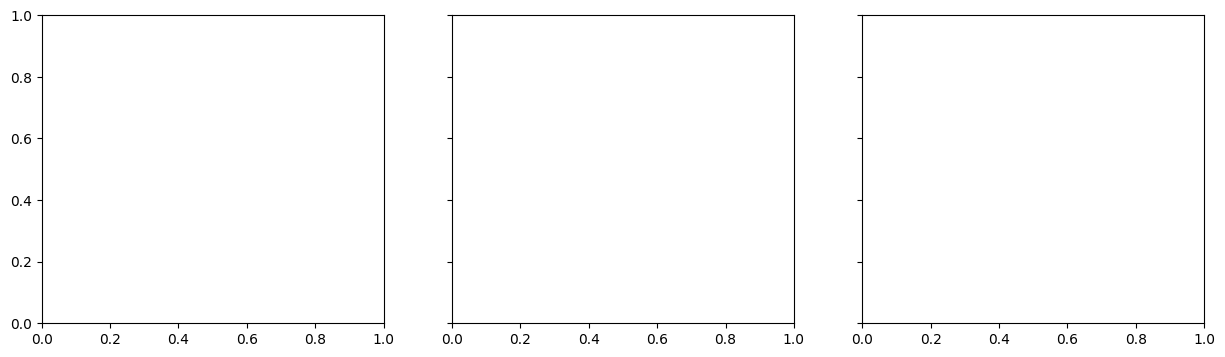

In [19]:
# AdamW
plot_layers_for_category(
    "AdamW",
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    use_cache=True,
    print_end_stats=True,   # <- this is the key
)

# Muon+NS (QKV, O, FFN)
plot_layers_for_category(
    "Muon-NS-All",
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    use_cache=True,
    print_end_stats=True,
)

# Muon+PE (QKV, O, FFN)
plot_layers_for_category(
    "Muon-PE-All",
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    use_cache=True,
    print_end_stats=True,
)

# Muon+NS(VO/FFN)
plot_layers_for_category(
    "Muon-NS-VOFFN",
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    use_cache=True,
    print_end_stats=True,
)

# Muon+PE(VO/FFN)
plot_layers_for_category(
    "Muon-PE-VOFFN",
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    use_cache=True,
    print_end_stats=True,
)

In [27]:
def download_all_plot_data(
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    sweep_ids=VARIANT_SWEEP_IDS,
):
    """Download and cache all data needed for plotting.

    This hits W&B once to pull:
    - Attention entropy metrics for each (category, layer) pair.
    - Train/val loss by optimizer variant for the configured sweeps.
    - Train/loss per learning rate for each attention category's sweeps.

    Results are saved under plotting/cache/ as pickled DataFrames, and
    subsequent plotting calls (plot_all_layers, plot_all_variants_from_sweeps,
    plot_train_loss_for_attn_category) will load from these caches instead of
    re-querying W&B.
    """
    PLOTTING_CACHE_DIR.mkdir(parents=True, exist_ok=True)

    # Attention entropy caches
    for category_name, ids in categories.items():
        for layer in layers:
            print(f"[download] attn entropy for {category_name}, layer {layer}...")
            df = get_attn_entropy_for_ids(ids, layer)
            if df.empty:
                print("  (no data)")
                continue
            path = _attn_cache_path(category_name, layer)
            df.to_pickle(path)
            print(f"  saved to {path}")

    # Variant loss caches (optimizer variants sweep)
    for metric_key in ("train/loss", "val/loss"):
        print(f"[download] {metric_key} for optimizer variants...")
        df = get_loss_by_variant(metric_key, sweep_ids=sweep_ids)
        if df.empty:
            print("  (no data)")
            continue
        path = _variant_cache_path(metric_key, sweep_ids)
        df.to_pickle(path)
        print(f"  saved to {path}")

    # Train loss caches for attention categories (per LR)
    for category_name, ids in categories.items():
        print(f"[download] train/loss for {category_name} (attn sweeps)...")
        df = get_train_loss_for_attn_category(category_name, ids=ids)
        if df.empty:
            print("  (no data)")
            continue
        path = _train_loss_cache_path_for_category(category_name)
        df.to_pickle(path)
        print(f"  saved to {path}")

    print("Done. Future plotting calls will use cached data unless use_cache=False.")

In [28]:
download_all_plot_data(layers=(0, 5, 11))

[download] attn entropy for AdamW, layer 0...
  saved to plotting/cache/attn_AdamW_layer0.pkl
[download] attn entropy for AdamW, layer 5...
  saved to plotting/cache/attn_AdamW_layer5.pkl
[download] attn entropy for AdamW, layer 11...
  saved to plotting/cache/attn_AdamW_layer11.pkl
[download] attn entropy for Muon-NS-All, layer 0...
  saved to plotting/cache/attn_Muon-NS-All_layer0.pkl
[download] attn entropy for Muon-NS-All, layer 5...
  saved to plotting/cache/attn_Muon-NS-All_layer5.pkl
[download] attn entropy for Muon-NS-All, layer 11...
  saved to plotting/cache/attn_Muon-NS-All_layer11.pkl
[download] attn entropy for Muon-NS-VOFFN, layer 0...
  saved to plotting/cache/attn_Muon-NS-VOFFN_layer0.pkl
[download] attn entropy for Muon-NS-VOFFN, layer 5...
  saved to plotting/cache/attn_Muon-NS-VOFFN_layer5.pkl
[download] attn entropy for Muon-NS-VOFFN, layer 11...
  saved to plotting/cache/attn_Muon-NS-VOFFN_layer11.pkl
[download] attn entropy for Muon-PE-All, layer 0...
  saved to p

In [29]:

# W&B project info
ENTITY = "justin_yang-university-of-california-berkeley"
PROJECT = "cs182-project-GPT-opt"

# Local cache directory for plotting data (ignored by git)
PLOTTING_CACHE_DIR = Path("plotting") / "cache"
PLOTTING_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Map high-level optimizer categories to sweep IDs or run IDs.
ATTN_CATEGORIES = {
    "AdamW": ["pxrm9xt8", "hkw05gba", "eifb7cyl", "4uytpec5"],
    "Muon-NS-All": ["qmzevjll", "lh2tzeh1", "capygls4"],
    "Muon-NS-VOFFN": ["88vr9lps"],
    "Muon-PE-All": ["emzbw2qc", "q02rln6i"],
    "Muon-PE-VOFFN": ["67g7mm51"],
}

# Titles for the attention entropy grid
ATTN_CATEGORY_TITLES = {
    "AdamW": "AdamW",
    "Muon-NS-All": "Muon Newton-Schulz (QKV, O, FFN)",
    "Muon-NS-VOFFN": "Muon Newton-Schulz (V, O, FFN)",
    "Muon-PE-All": "Muon Polar Express (QKV, O, FFN)",
    "Muon-PE-VOFFN": "Muon Polar Express (V, O, FFN)",
}

# Plot layout knobs for the combined attention grid
DEFAULT_YLIM = (0.0, 6.0)
USE_EPOCH_X = True
EPOCH_MAX = 0.3  # runs are 0.3 epochs

COMBINED_LEGEND_Y = 1.08
COMBINED_SUBTITLE_Y = 0.81
COMBINED_TITLE_Y = 0.87
COMBINED_TIGHT_RECT = (0, 0, 1, 0.86)
COMBINED_SUBTITLE_X_NUDGE = {
    "AdamW": -0.07,
    "Muon-NS-All": -0.03,
    "Muon-PE-All": 0,
    "Muon-NS-VOFFN": 0.03,
    "Muon-PE-VOFFN": 0.07,
}


In [30]:

def _collect_runs_for_ids(ids, entity=ENTITY, project=PROJECT):
    """Given a list of sweep IDs and/or run IDs, return a flat list of runs."""
    api = wandb.Api()
    runs = []
    for _id in ids:
        try:
            sweep = api.sweep(f"{entity}/{project}/{_id}")
            runs.extend(list(sweep.runs))
            continue
        except Exception:
            pass
        try:
            run = api.run(f"{entity}/{project}/{_id}")
            runs.append(run)
        except Exception as e:
            print(f"Warning: could not load sweep or run '{_id}': {e}")
    return runs


def _attn_cache_path(category_name, layer):
    safe_cat = str(category_name).replace("/", "_")
    return PLOTTING_CACHE_DIR / f"attn_{safe_cat}_layer{layer}.pkl"


def _load_attn_cache(category_name, layer):
    path = _attn_cache_path(category_name, layer)
    if path.exists():
        try:
            return pd.read_pickle(path)
        except Exception as e:
            print(f"Warning: failed to read attention cache {path}: {e}")
    return None


def _save_attn_cache(category_name, layer, df):
    path = _attn_cache_path(category_name, layer)
    try:
        df.to_pickle(path)
    except Exception as e:
        print(f"Warning: failed to write attention cache {path}: {e}")


In [31]:

def get_attn_entropy_for_ids(ids, layer, entity=ENTITY, project=PROJECT):
    """Aggregate attn/layer{layer}/entropy/mean across runs."""
    metric_key = f"attn/layer{layer}/entropy/mean"
    runs = _collect_runs_for_ids(ids, entity=entity, project=project)
    records = []

    for run in runs:
        lr = None
        try:
            lr = run.config["optimizer_params"]["args"]["lr"]
        except Exception:
            lr = run.config.get("optimizer_params.args.lr", None)
        if lr is None:
            continue

        for row in run.scan_history():
            if metric_key not in row:
                continue
            val = row[metric_key]
            step = row.get("_step")
            if step is None:
                continue
            if val is None:
                continue
            records.append({"lr": float(lr), "step": int(step), "value": float(val), "run_id": run.id})

    if not records:
        return pd.DataFrame(columns=["lr", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["lr", "step"])["value"].agg(["mean", "std", "count"]).reset_index().rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["lr", "step"])
    return grouped


def plot_attn_entropy_category(
    category_name,
    ids,
    layer,
    ax=None,
    ylim=DEFAULT_YLIM,
    add_legend=True,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    print_end_stats=False,
):
    df = _load_attn_cache(category_name, layer) if use_cache else None
    if df is None:
        df = get_attn_entropy_for_ids(ids, layer)
        if use_cache and not df.empty:
            _save_attn_cache(category_name, layer, df)

    if category_name == "AdamW" and not df.empty:
        df = df[df["lr"] <= 0.0024 + 1e-12]
    if lr_min is not None:
        df = df[df["lr"] >= lr_min]
    if lr_max is not None:
        df = df[df["lr"] <= lr_max]

    if df.empty:
        print(f"No data found for {category_name}, layer {layer} after LR filtering.")
        return

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    sns.set_style("whitegrid")
    min_step = df["step"].min() if not df.empty else 0
    max_step = df["step"].max() if not df.empty else 0
    span = max(max_step - min_step, 1)

    for lr, sub in df.groupby("lr"):
        sub = sub.sort_values("step")
        steps = sub["step"].values.astype(float)
        mean_vals = sub["mean"].values
        sem_vals = sub["sem"].fillna(0.0).values

        if use_epoch_x:
            x_vals = (steps - min_step) / span * (epoch_max if epoch_max is not None else 1.0)
        else:
            x_vals = steps

        ax.plot(x_vals, mean_vals, label=f"{lr:g}")
        ax.fill_between(x_vals, mean_vals - sem_vals, mean_vals + sem_vals, alpha=0.25)

        if print_end_stats and len(mean_vals) > 0:
            final_mean = float(mean_vals[-1])
            final_sem = float(sem_vals[-1])
            lower = final_mean - final_sem
            upper = final_mean + final_sem
            print(
                f"{category_name}, layer {layer}, lr={lr:g}: "
                f"final mean={final_mean:.4f}, lower={lower:.4f}, upper={upper:.4f}"
            )

    title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)
    ax.set_title(f"Layer {layer} Attention Entropy for {title_base}", pad=14)
    ax.set_ylabel("Mean Entropy")
    if ylim is not None:
        ax.set_ylim(*ylim)

    if use_epoch_x:
        ax.set_xlabel("Epoch")
        if epoch_max is not None:
            ax.set_xlim(0.0, epoch_max)
    else:
        ax.set_xlabel("Step")
        ax.set_xlim(left=0.0)

    ax.tick_params(axis="y", labelleft=True)
    if add_legend:
        ax.legend(title="Learning Rate", fontsize=8)

    return ax


def plot_all_categories_combined(
    categories_order=("AdamW", "Muon-NS-All", "Muon-PE-All", "Muon-NS-VOFFN", "Muon-PE-VOFFN"),
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    lr_ranges_by_category=None,
    base_lr_by_category=None,
    print_end_stats=False,
):
    n_rows = len(layers)
    n_cols = len(categories_order)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows), sharex=True, sharey=True)
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    for col, category_name in enumerate(categories_order):
        if category_name not in categories:
            print(f"Warning: category {category_name} missing from ATTN_CATEGORIES; skipping column.")
            continue
        ids = categories[category_name]
        cat_lr_min, cat_lr_max = lr_min, lr_max
        if lr_ranges_by_category and category_name in lr_ranges_by_category:
            cat_lr_min, cat_lr_max = lr_ranges_by_category[category_name]

        for row, layer in enumerate(layers):
            ax = axes[row, col]
            add_legend = row == 0
            plot_attn_entropy_category(
                category_name,
                ids,
                layer,
                ax=ax,
                ylim=ylim,
                add_legend=add_legend,
                use_epoch_x=use_epoch_x,
                epoch_max=epoch_max,
                use_cache=use_cache,
                lr_min=cat_lr_min,
                lr_max=cat_lr_max,
                print_end_stats=print_end_stats,
            )
            if row > 0:
                ax.set_xlabel("")
            if col > 0:
                ax.set_ylabel("")

        top_ax = axes[0, col]
        handles, labels = top_ax.get_legend_handles_labels()
        if top_ax.get_legend() is not None:
            top_ax.get_legend().remove()
        if handles and labels:
            fig.legend(
                handles,
                labels,
                title="Learning Rate",
                loc="upper center",
                bbox_to_anchor=(0.5, COMBINED_LEGEND_Y),
                ncol=min(4, len(labels)),
                fontsize=8,
            )
        subtitle = ATTN_CATEGORY_TITLES.get(category_name, category_name)
        x0, x1 = top_ax.get_position().x0, top_ax.get_position().x1
        x_center = 0.5 * (x0 + x1) + COMBINED_SUBTITLE_X_NUDGE.get(category_name, 0)
        fig.text(x_center, COMBINED_SUBTITLE_Y, subtitle, ha="center", va="center", fontsize=10, fontweight="bold")

    fig.suptitle("Attention Entropy vs Epoch", y=COMBINED_TITLE_Y, fontsize=16, fontweight="bold")
    fig.tight_layout(rect=COMBINED_TIGHT_RECT)
    plt.show()
    return fig, axes


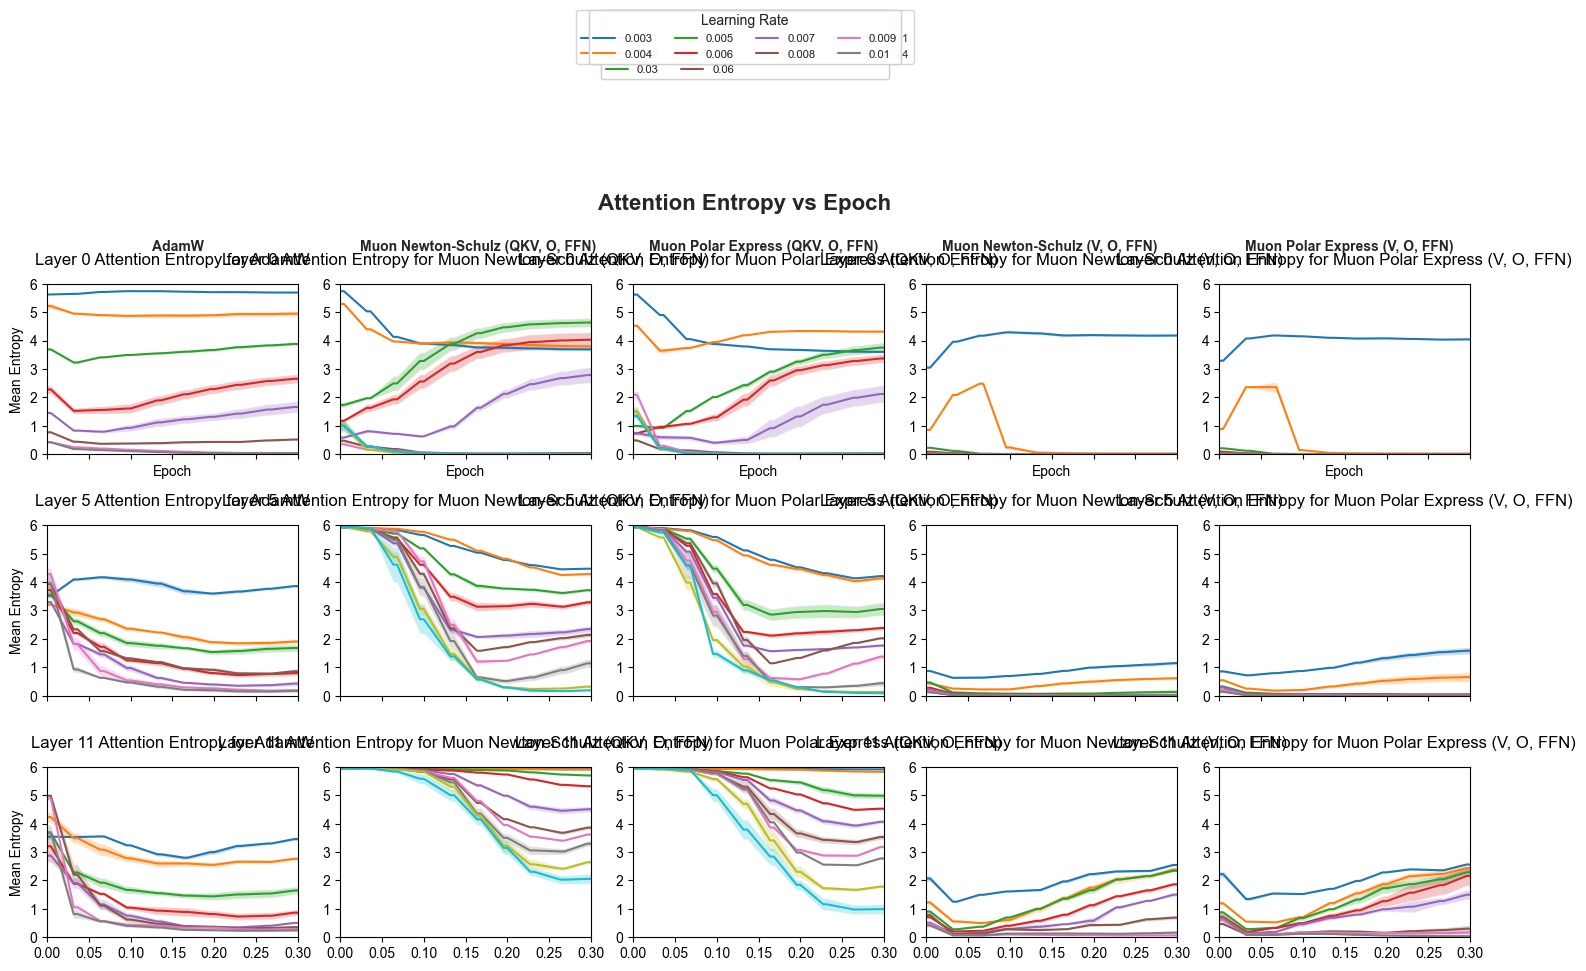

In [32]:

# Combined attention entropy grid (per-category LR ranges)
lr_ranges = {
    "AdamW": (0.0003, 0.0024),
    "Muon-NS-All": (0.01, 0.1),
    "Muon-PE-All": (0.01, 0.1),
    "Muon-NS-VOFFN": (0.003, 0.01),
    "Muon-PE-VOFFN": (0.003, 0.01),
}

base_lrs = {
    "AdamW": 0.0003,
    "Muon-NS-All": 0.01,
    "Muon-PE-All": 0.01,
    "Muon-NS-VOFFN": 0.003,
    "Muon-PE-VOFFN": 0.003,
}

fig, axes = plot_all_categories_combined(
    lr_ranges_by_category=lr_ranges,
    base_lr_by_category=base_lrs,
    print_end_stats=False,
)


In [33]:

# Benji branch plots: condition number, effective rank, spectral gap for Polar safety sweep

def get_data(sweep_id, optimizer_param_name, optimizer_param_vals, update, layer, matrix, metric):
    update_prefix = "update_" if update else ""
    api = wandb.Api()
    sweep = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}")
    data = {val: [] for val in optimizer_param_vals}

    for run in sweep.runs:
        run_param = run.config["optimizer_params"]["args"][optimizer_param_name]
        data[run_param].append(
            np.array([step.get(f"svd/{update_prefix}layer{layer}_{matrix}/{metric}") for step in run.scan_history()])
        )
    return data


def plot_data(
    sweep_id,
    param_name,
    param_id,
    param_vals,
    update,
    layer,
    matrix,
    metric,
    start,
    end,
    use_ci=False,
    log_scale=False,
    plot_med=True,
    save_plot=False,
):
    print("Getting Data...")
    data = get_data(sweep_id, param_id, param_vals, update, layer, matrix, metric)
    update_prefix = "update_" if update else ""

    df = {}
    for val in param_vals:
        arrays = data[val]
        valid_mask = arrays[0] != None
        steps = np.where(valid_mask)[0]
        valid_arrays = [x[valid_mask] for x in arrays]
        valid_arrays = np.asarray(valid_arrays, dtype=float)

        if use_ci:
            med_vec = np.mean(np.stack(valid_arrays), axis=0)
            std_vec = np.std(np.stack(valid_arrays), axis=0)
            N = np.stack(valid_arrays).shape[0]
            sem_vec = std_vec / np.sqrt(N)
            min_vec = med_vec - 1.96 * sem_vec
            max_vec = med_vec + 1.96 * sem_vec
        else:
            med_vec = np.median(np.stack(valid_arrays), axis=0)
            min_vec = np.min(np.stack(valid_arrays), axis=0)
            max_vec = np.max(np.stack(valid_arrays), axis=0)

        med_vec = np.asarray(med_vec, dtype=float)
        min_vec = np.asarray(min_vec, dtype=float)
        max_vec = np.asarray(max_vec, dtype=float)

        if log_scale:
            med_vec = np.log(med_vec)
            min_vec = np.log(min_vec)
            max_vec = np.log(max_vec)

        df[f"med_vec_{val}"] = med_vec
        df[f"min_vec_{val}"] = min_vec
        df[f"max_vec_{val}"] = max_vec

    df["Step"] = steps
    df = pd.DataFrame(df)
    df_iloc = df.iloc[start : end + 1]

    print("Plotting Data...")
    sns.set_style("whitegrid")
    for val in param_vals:
        if plot_med:
            sns.lineplot(data=df_iloc, x="Step", y=f"med_vec_{val}")
        steps = df_iloc["Step"]
        min_vec = df_iloc[f"min_vec_{val}"]
        max_vec = df_iloc[f"max_vec_{val}"]
        plt.fill_between(steps, min_vec, max_vec, alpha=0.3, label=f"{val}")

    plt.title(f"{update_prefix.replace('_', '').title()} Layer {layer} {matrix.title()} - {metric.replace('_', ' ').title()}")
    plt.xlabel("Step")
    ylabel = f"{metric.replace('_', ' ').title()} (Log Scale)" if log_scale else metric.replace("_", " ").title()
    plt.ylabel(ylabel)
    plt.legend(title=param_name)

    if save_plot:
        Path("plotting/plots").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"./plotting/plots/{param_id}_{metric}_layer{layer}.jpg")
        print("Plot Saved.")

    plt.show()


Getting Data...
Plotting Data...
Plot Saved.


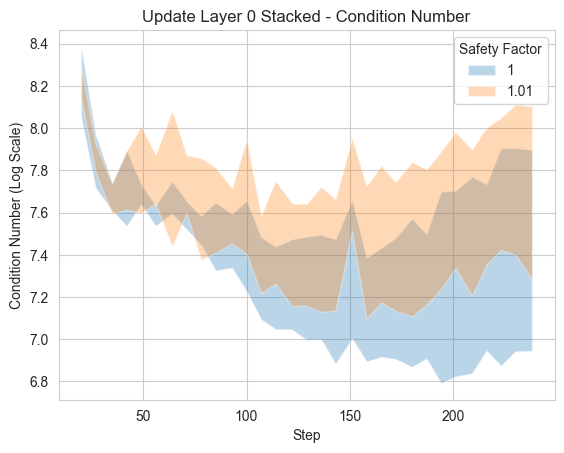

Getting Data...


KeyboardInterrupt: 

In [34]:

# Reproduce Benji's polar_safety sweep plots
POLAR_SWEEP_ID = "5pllqyjx"
PARAM_NAME = "Safety Factor"
PARAM_ID = "polar_safety"
PARAM_VALS = [1, 1.01]

# Condition number (layers 0,5,11), log-scale
for layer in (0, 5, 11):
    plot_data(
        POLAR_SWEEP_ID,
        PARAM_NAME,
        PARAM_ID,
        PARAM_VALS,
        update=True,
        layer=layer,
        matrix="stacked",
        metric="condition_number",
        start=2,
        end=32,
        use_ci=True,
        log_scale=True,
        plot_med=False,
        save_plot=True,
    )

# Effective rank (layers 0,5,11)
for layer in (0, 5, 11):
    plot_data(
        POLAR_SWEEP_ID,
        PARAM_NAME,
        PARAM_ID,
        PARAM_VALS,
        update=True,
        layer=layer,
        matrix="stacked",
        metric="effective_rank",
        start=1,
        end=32,
        use_ci=True,
        log_scale=False,
        plot_med=False,
        save_plot=True,
    )

# Spectral gap (layers 0,5,11)
for layer in (0, 5, 11):
    plot_data(
        POLAR_SWEEP_ID,
        PARAM_NAME,
        PARAM_ID,
        PARAM_VALS,
        update=True,
        layer=layer,
        matrix="stacked",
        metric="spectral_gap",
        start=0,
        end=32,
        use_ci=False,
        log_scale=False,
        plot_med=False,
        save_plot=True,
    )


In [35]:

# Variant-based plots for Muon/PE/AdamW sweeps
VARIANT_SWEEP_IDS = ["vqkcitxv", "ov703ihc", "js8l8c7m"]
VARIANT_TITLE_MAP = {
    "pe_all": "Muon+PE",
    "ns_all": "Muon+NS",
    "pe_voffn": "Muon+PE(VO/FFN)",
    "ns_voffn": "Muon+NS(VO/FFN)",
    "pe_mod_all": "Muon+PE (cheap)",
    "adamw": "AdamW",
}
CANONICAL_VARIANTS = [
    "AdamW",
    "Muon+NS(VO/FFN)",
    "Muon+NS",
    "Muon+PE(VO/FFN)",
    "Muon+PE",
    "Muon+PE (cheap)",
    "Muon+PE (split)",
]


In [36]:

def _collect_variant_runs(sweep_ids=VARIANT_SWEEP_IDS, entity=ENTITY, project=PROJECT):
    api = wandb.Api()
    runs = []
    for sid in sweep_ids:
        try:
            sweep = api.sweep(f"{entity}/{project}/{sid}")
            runs.extend(list(sweep.runs))
        except Exception as e:
            print(f"Warning: could not load sweep '{sid}': {e}")
    return runs


def _get_variant_label(cfg):
    raw_variant = None
    muon_mode = None
    try:
        args = cfg["optimizer_params"]["args"]
        raw_variant = args.get("muon_variant")
        muon_mode = args.get("muon_mode")
    except Exception:
        pass
    if raw_variant is None:
        raw_variant = cfg.get("optimizer_params.args.muon_variant")
    if muon_mode is None:
        muon_mode = cfg.get("optimizer_params.args.muon_mode")
    if raw_variant is None:
        raw_variant = "adamw"
    if muon_mode == "split_qkv":
        return "Muon+PE (split)"
    return VARIANT_TITLE_MAP.get(raw_variant, raw_variant)


def _variant_cache_path(metric_key, sweep_ids):
    safe_metric = metric_key.replace("/", "_")
    sid_part = "_".join(sorted(sweep_ids))
    return PLOTTING_CACHE_DIR / f"variants_{safe_metric}_{sid_part}.pkl"


def _load_variant_cache(metric_key, sweep_ids):
    path = _variant_cache_path(metric_key, sweep_ids)
    if path.exists():
        try:
            return pd.read_pickle(path)
        except Exception as e:
            print(f"Warning: failed to read variant cache {path}: {e}")
    return None


def _save_variant_cache(metric_key, sweep_ids, df):
    path = _variant_cache_path(metric_key, sweep_ids)
    try:
        df.to_pickle(path)
    except Exception as e:
        print(f"Warning: failed to write variant cache {path}: {e}")


def get_loss_by_variant(metric_key, sweep_ids=VARIANT_SWEEP_IDS, entity=ENTITY, project=PROJECT):
    runs = _collect_variant_runs(sweep_ids=sweep_ids, entity=entity, project=project)
    records = []

    for run in runs:
        cfg = run.config
        variant = _get_variant_label(cfg)
        for i, row in enumerate(run.scan_history()):
            if metric_key not in row:
                continue
            val = row[metric_key]
            step = row.get("_step")
            if step is None:
                step = row.get("epoch")
            if step is None:
                step = i
            if val is None:
                continue
            records.append({"variant": variant, "step": float(step), "value": float(val), "run_id": run.id})

    if not records:
        print(f"{metric_key}: no records found in sweeps {sweep_ids}")
        return pd.DataFrame(columns=["variant", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["variant", "step"])["value"].agg(["mean", "std", "count"]).reset_index().rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["variant", "step"])
    print(f"{metric_key}: found variants {sorted(grouped['variant'].unique())}")
    return grouped


In [37]:

def plot_full_and_zoomed_variants(
    sweep_ids=VARIANT_SWEEP_IDS,
    zoom_window=(0.95, 1.0),
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    include_split=True,
):
    if use_cache:
        train_df_full = _load_variant_cache("train/loss", sweep_ids)
        val_df_full = _load_variant_cache("val/loss", sweep_ids)
        if train_df_full is None:
            train_df_full = get_loss_by_variant("train/loss", sweep_ids=sweep_ids)
            _save_variant_cache("train/loss", sweep_ids, train_df_full)
        if val_df_full is None:
            val_df_full = get_loss_by_variant("val/loss", sweep_ids=sweep_ids)
            _save_variant_cache("val/loss", sweep_ids, val_df_full)
    else:
        train_df_full = get_loss_by_variant("train/loss", sweep_ids=sweep_ids)
        val_df_full = get_loss_by_variant("val/loss", sweep_ids=sweep_ids)

    if train_df_full.empty and val_df_full.empty:
        print("No loss data found for the specified sweeps.")
        return

    train_df_zoom = train_df_full[train_df_full["variant"] != "AdamW"] if not train_df_full.empty else train_df_full
    val_df_zoom = val_df_full[val_df_full["variant"] != "AdamW"] if not val_df_full.empty else val_df_full

    variants_full = set()
    if not train_df_full.empty:
        variants_full.update(train_df_full["variant"].unique())
    if not val_df_full.empty:
        variants_full.update(val_df_full["variant"].unique())
    variants_full = [v for v in CANONICAL_VARIANTS if v in variants_full]

    variants_zoom = set()
    if not train_df_zoom.empty:
        variants_zoom.update(train_df_zoom["variant"].unique())
    if not val_df_zoom.empty:
        variants_zoom.update(val_df_zoom["variant"].unique())
    variants_zoom = [v for v in CANONICAL_VARIANTS if v in variants_zoom]

    if not include_split:
        variants_full = [v for v in variants_full if v != "Muon+PE (split)"]
        variants_zoom = [v for v in variants_zoom if v != "Muon+PE (split)"]

    if not variants_full:
        print("No variants to plot after filtering.")
        return

    palette = sns.color_palette(n_colors=len(CANONICAL_VARIANTS))
    color_map = {name: palette[i] for i, name in enumerate(CANONICAL_VARIANTS)}

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax_train_full, ax_val_full = axes[0]
    ax_train_zoom, ax_val_zoom = axes[1]

    def _plot_full(df, ax, ylabel):
        if df.empty:
            ax.set_visible(False)
            return
        sns.set_style("whitegrid")
        min_step = df["step"].min() if not df.empty else 0.0
        max_step = df["step"].max() if not df.empty else 0.0
        span = max(max_step - min_step, 1e-8)
        for variant in variants_full:
            sub = df[df["variant"] == variant]
            if sub.empty:
                continue
            sub = sub.sort_values("step")
            steps = sub["step"].values.astype(float)
            mean_vals = sub["mean"].values
            sem_vals = sub["sem"].fillna(0.0).values
            x_vals = (steps - min_step) / span * (epoch_max if epoch_max is not None else 1.0) if use_epoch_x else steps
            color = color_map.get(variant)
            ax.plot(x_vals, mean_vals, color=color, alpha=1.0, label=variant)
            ax.fill_between(x_vals, mean_vals - sem_vals, mean_vals + sem_vals, alpha=0.2, color=color)
        if use_epoch_x:
            if epoch_max is not None:
                ax.set_xlim(0.0, epoch_max)
            ax.set_xlabel("Epoch")
        else:
            ax.set_xlim(left=0.0)
            ax.set_xlabel("Step")
        ax.set_ylabel(ylabel)
        ax.tick_params(axis="y", labelleft=True)

    def _plot_zoom(df, ax, ylabel):
        if df.empty:
            ax.set_visible(False)
            return
        sns.set_style("whitegrid")
        emin, emax = zoom_window
        min_step = df["step"].min() if not df.empty else 0.0
        max_step = df["step"].max() if not df.empty else 0.0
        span = max(max_step - min_step, 1e-8)
        df_local = df.copy()
        df_local["epoch"] = (df_local["step"] - min_step) / span * (epoch_max if epoch_max is not None else 1.0)
        zoom_ymin, zoom_ymax = None, None
        for variant in variants_zoom:
            sub = df_local[df_local["variant"] == variant]
            if sub.empty:
                continue
            sub = sub.sort_values("step")
            x_vals = sub["epoch"].values
            mean_vals = sub["mean"].values
            sem_vals = sub["sem"].fillna(0.0).values
            color = color_map.get(variant)
            ax.plot(x_vals, mean_vals, color=color, alpha=0.5)
            mask = (x_vals >= emin) & (x_vals <= emax)
            x_zoom = x_vals[mask]
            mean_zoom = mean_vals[mask]
            sem_zoom = sem_vals[mask]
            boundary_x = []
            boundary_mean = []
            boundary_sem = []
            if x_vals.size >= 2:
                for b in (emin, emax):
                    j = np.searchsorted(x_vals, b)
                    if 0 < j < x_vals.size:
                        x0, x1 = x_vals[j - 1], x_vals[j]
                        if x1 == x0:
                            continue
                        t = (b - x0) / (x1 - x0)
                        m = mean_vals[j - 1] + t * (mean_vals[j] - mean_vals[j - 1])
                        s = sem_vals[j - 1] + t * (sem_vals[j] - sem_vals[j - 1])
                        boundary_x.append(b)
                        boundary_mean.append(m)
                        boundary_sem.append(s)
            if boundary_x:
                x_ext = np.concatenate([x_zoom, np.array(boundary_x, dtype=float)])
                mean_ext = np.concatenate([mean_zoom, np.array(boundary_mean, dtype=float)])
                sem_ext = np.concatenate([sem_zoom, np.array(boundary_sem, dtype=float)])
                order = np.argsort(x_ext)
                x_zoom = x_ext[order]
                mean_zoom = mean_ext[order]
                sem_zoom = sem_ext[order]
            if x_zoom.size == 0:
                continue
            ax.plot(x_zoom, mean_zoom, color=color, alpha=1.0)
            ax.fill_between(x_zoom, mean_zoom - sem_zoom, mean_zoom + sem_zoom, alpha=0.2, color=color)
            cur_min = float((mean_zoom - sem_zoom).min())
            cur_max = float((mean_zoom + sem_zoom).max())
            zoom_ymin = cur_min if zoom_ymin is None else min(zoom_ymin, cur_min)
            zoom_ymax = cur_max if zoom_ymax is None else max(zoom_ymax, cur_max)
        ax.set_xlim(emin, emax)
        if zoom_ymin is not None and zoom_ymax is not None:
            pad = max(0.05 * (zoom_ymax - zoom_ymin), 0.02)
            ax.set_ylim(zoom_ymin - pad, zoom_ymax + pad)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis="y", labelleft=True)

    _plot_full(train_df_full, ax_train_full, "Train Loss")
    _plot_full(val_df_full, ax_val_full, "Val Loss")
    _plot_zoom(train_df_zoom, ax_train_zoom, "Train Loss")
    _plot_zoom(val_df_zoom, ax_val_zoom, "Val Loss")

    xlabel = "Epoch" if use_epoch_x else "Step"
    ax_train_zoom.set_xlabel(xlabel)
    ax_val_zoom.set_xlabel(xlabel)

    handles, labels = ax_train_full.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Optimizer Variant",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.97),
        ncol=min(3, len(labels)),
        fontsize=8,
    )

    fig.suptitle("Train and Validation Loss by Optimizer Variant", y=0.99, fontsize=16, fontweight="bold")
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()
    return fig, axes


@contextmanager
def _temporary_variants(temp_variants):
    global CANONICAL_VARIANTS
    old_variants = CANONICAL_VARIANTS
    try:
        CANONICAL_VARIANTS = list(temp_variants)
        yield
    finally:
        CANONICAL_VARIANTS = old_variants


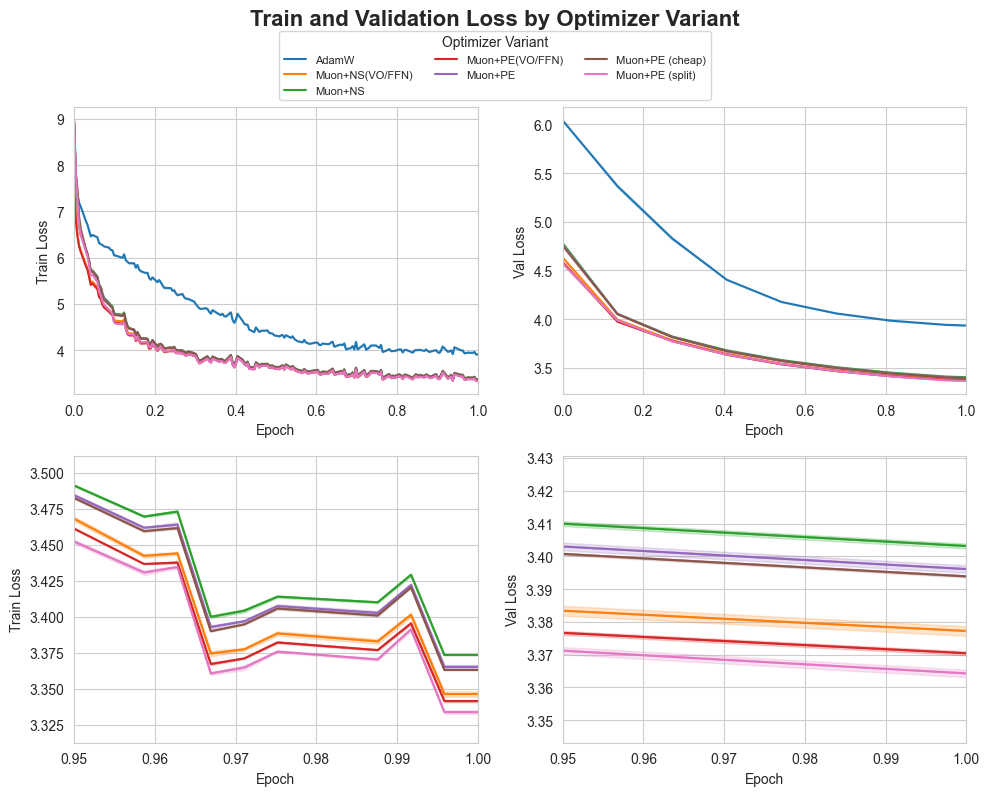

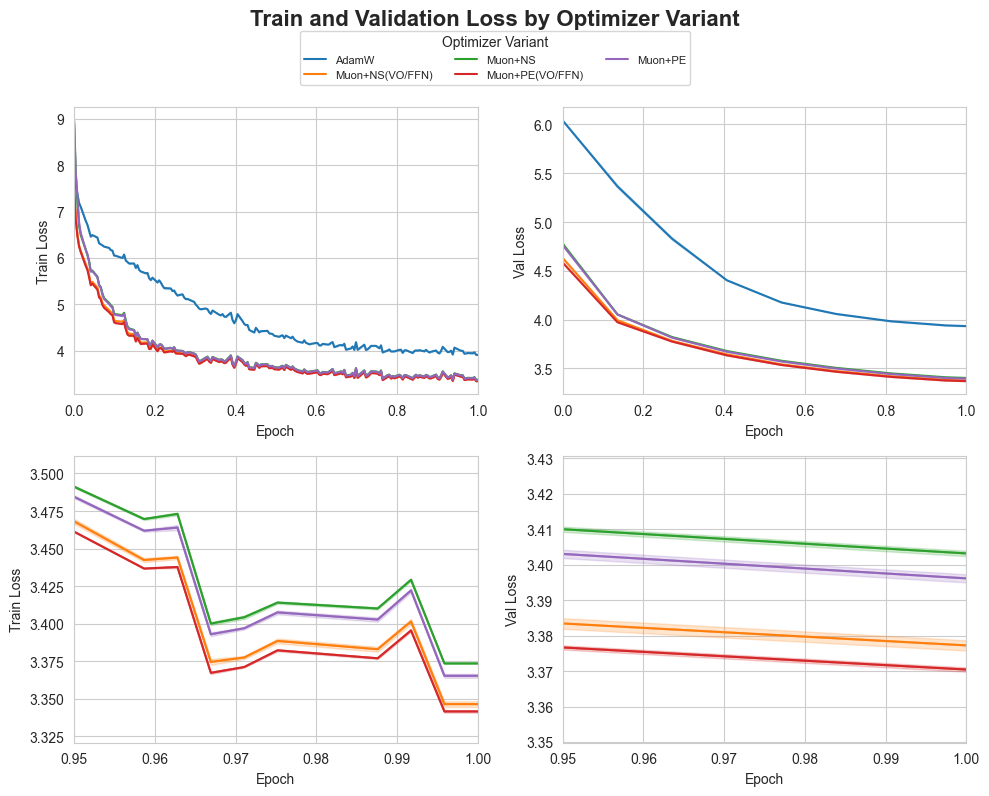

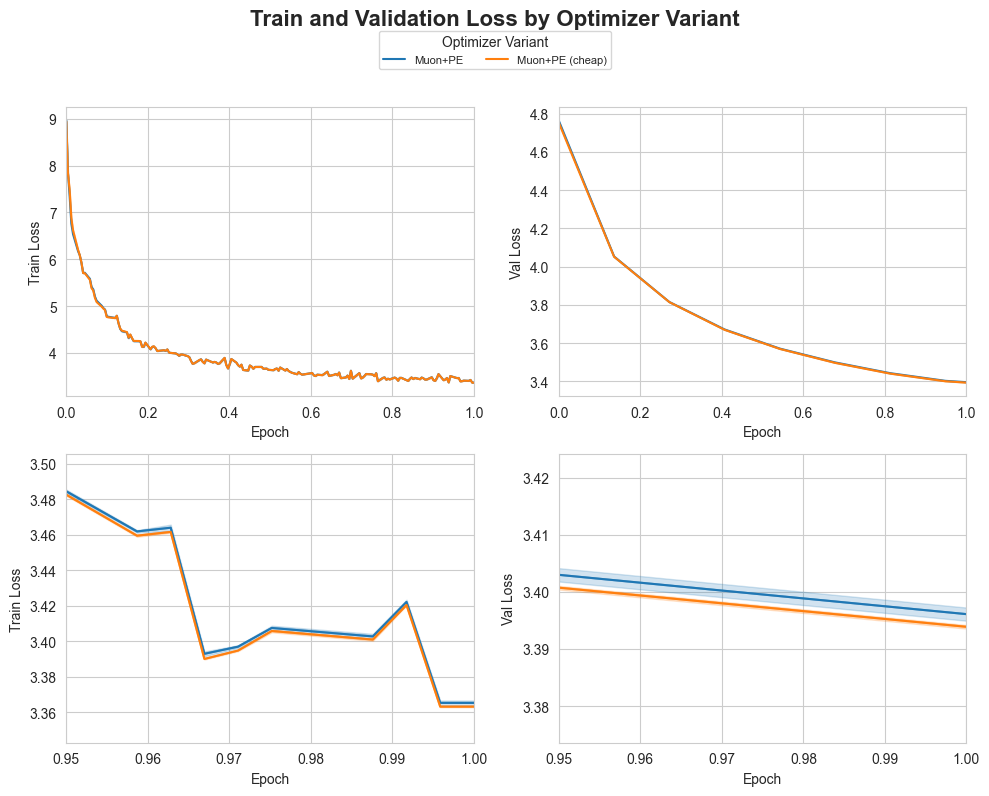

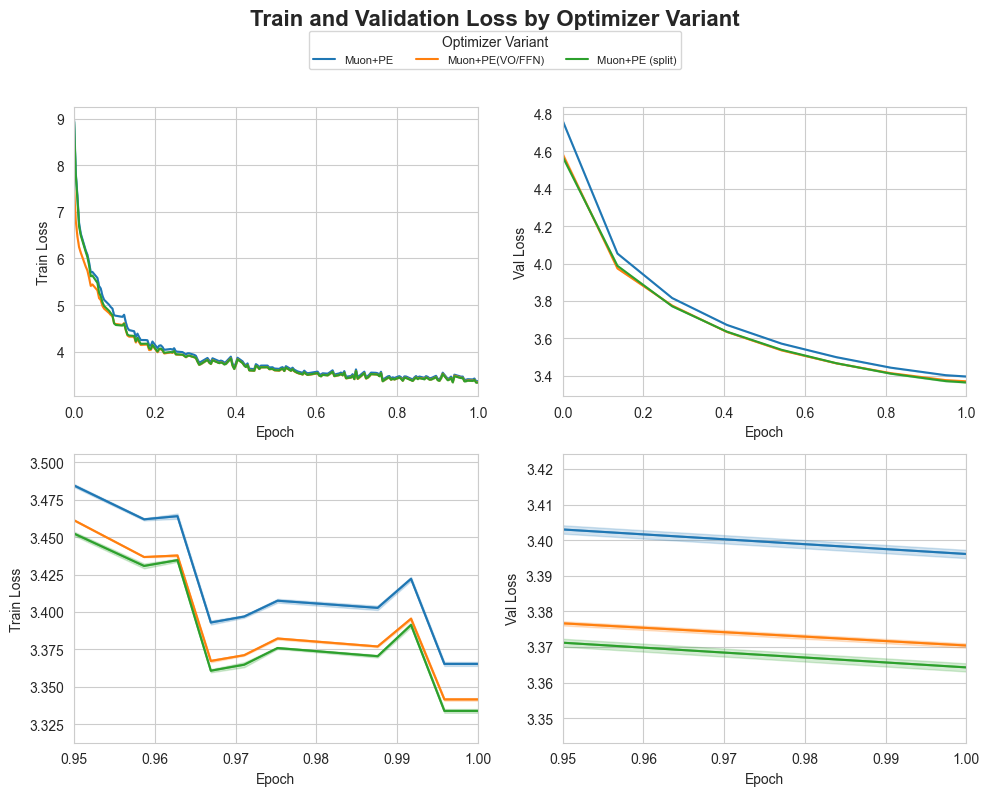

In [38]:

# Default full + zoomed variants plot
fig, axes = plot_full_and_zoomed_variants(
    sweep_ids=VARIANT_SWEEP_IDS,
    zoom_window=(0.95, 1.0),
    use_epoch_x=True,
    epoch_max=1.0,
    use_cache=True,
    include_split=True,
)

# Paper-specific subsets using temporary variant filtering
_base_variants = [v for v in CANONICAL_VARIANTS if v not in ("Muon+PE (cheap)", "Muon+PE (split)")]
with _temporary_variants(_base_variants):
    plot_full_and_zoomed_variants(zoom_window=(0.95, 1.0), epoch_max=1.0, include_split=False)

_pe_and_cheap = ["Muon+PE", "Muon+PE (cheap)"]
with _temporary_variants(_pe_and_cheap):
    plot_full_and_zoomed_variants(zoom_window=(0.95, 1.0), epoch_max=1.0, include_split=True)

_pe_family = ["Muon+PE", "Muon+PE(VO/FFN)", "Muon+PE (split)"]
with _temporary_variants(_pe_family):
    plot_full_and_zoomed_variants(zoom_window=(0.95, 1.0), epoch_max=1.0, include_split=True)


---
# Analysis (merged from analyze-data.ipynb)

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
DATA_DIR = "./data"
MANIFEST_FILE = os.path.join(DATA_DIR, "runs_manifest.csv")
SWEEPS_DIR = os.path.join(DATA_DIR, "sweeps")

In [40]:
# --- 1. LOAD MANIFEST (The Phonebook) ---
def load_manifest():
    """Loads the lightweight metadata index."""
    if not os.path.exists(MANIFEST_FILE):
        raise FileNotFoundError("Manifest not found! Run the downloader script first.")
    return pd.read_csv(MANIFEST_FILE)

# --- 2. FIND SWEEP ID (The Search Tool) ---
def find_sweep_id(manifest, search_term):
    """
    Helps you find the sweep_id based on a run name or config.
    Example: find_sweep_id(manifest, "polar_safety")
    """
    # Search in config keys
    matches = manifest[manifest.apply(lambda row: row.astype(str).str.contains(search_term).any(), axis=1)]

    if matches.empty:
        print(f"No sweeps found matching '{search_term}'")
        return None

    unique_sweeps = matches["sweep_id"].unique()
    print(f"Found {len(unique_sweeps)} matching sweeps:")
    for sw in unique_sweeps:
        # Get a sample run name to help identify it
        sample_name = matches[matches["sweep_id"] == sw].iloc[0]["run_name"]
        print(f"  - ID: {sw} (Sample Run: {sample_name})")

    return unique_sweeps[0] if len(unique_sweeps) == 1 else unique_sweeps

# --- 3. LOAD SWEEP DATA (The Heavy Lifter) ---
def load_sweep_data(sweep_id, manifest):
    """
    Loads the time-series data for ONE sweep and joins it with Hyperparameters.
    """
    filepath = os.path.join(SWEEPS_DIR, f"sweep_{sweep_id}.csv")

    print(f"Loading data for Sweep {sweep_id}...")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    # 1. Load History (Metrics over time)z
    df_history = pd.read_csv(filepath, low_memory=False)

    # 2. Prepare Metadata (Hyperparameters)
    # Filter manifest to just this sweep's runs to speed up merge
    sweep_meta = manifest[manifest["sweep_id"] == sweep_id].copy()

    # Select useful columns (Config + Identifiers)
    # We grab everything starting with 'config_'
    meta_cols = ["run_id", "run_name", "state"] + \
                [c for c in sweep_meta.columns if c.startswith("config_")]

    # 3. Merge (SQL-style Join)
    # history.run_id <-> manifest.run_id
    df_merged = pd.merge(df_history, sweep_meta[meta_cols], on="run_id", how="left")

    print(f"Loaded {len(df_merged)} rows. Columns: {len(df_merged.columns)}")
    return df_merged

# --- 4. THE FAST PLOTTER (Updated for Flattened Configs) ---
def plot_sweep(df, x, y, skip=0, hue=None, title=None, log_scale=False):
    plt.figure(figsize=(10, 6))

    for hue_val in df[hue].unique():
            
        group = df[df[hue] == hue_val].iloc[skip:]
    
        sns.lineplot(
            data=group,
            x=x,
            y=y,
            #hue=hue,
            errorbar="sd"
        )

    if log_scale:
        plt.yscale("log")

    clean_title = title if title else f"{y} vs {x}"
    plt.title(clean_title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [41]:
# Load Metadata
manifest = load_manifest()

# Find the sweep where you tested "Safety Factor"
# This prints the ID you need (e.g., "5pllqyjx")
sweep_ids = find_sweep_id(manifest, "polar_safety")

FileNotFoundError: Manifest not found! Run the downloader script first.

In [42]:
df = load_sweep_data("5pllqyjx", manifest)
df["step_norm"] = df["_step"] / df["_step"].max()
# for val in df['config_optimizer_params.args.polar_safety'].unique():
#     print(val)
for col in df.columns:
    print(col)
# x = 'diag_log_step'
# y = 'svd/layer11_q/condition_number'
# x_cols = df.columns.str.contains(x)
# print("Found x Columns:")
# for col in df.columns[x_cols]:
#     print("\t", col)

# y_cols = df.columns.str.contains(y)
# print("Found y Columns:")
# for col in df.columns[y_cols]:
#     print("\t", col)

# assert sum(x_cols) == 1, "invalid number of columns found for x"
# assert sum(y_cols) == 1, "invalid number of columns found for y"

NameError: name 'manifest' is not defined

In [43]:
def plot_data(df, x, y_list, title_list, hue, start=0, end=1000, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4))
    plt.subplots_adjust(wspace=0.28)
    
    for plt_idx, y in enumerate(y_list):
        
        if x != "_step":
            x_cols = df.columns.str.contains(x)
            print("Found x Columns:")
            for col in df.columns[x_cols]:
                print(col)
            assert sum(x_cols) == 1, "invalid number of columns found for x"
        
        y_cols = df.columns.str.contains(y)
        print("Found y Columns:")
        for col in df.columns[y_cols]:
            print(col)
        assert sum(y_cols) == 1, "invalid number of columns found for y"
    
        print("Plotting Data...")
        sns.set_style("whitegrid")
        for val in df[hue].unique():
            df_grouped = df[df[hue] == val]
            df_clipped = df_grouped[(start <= df_grouped[x]) & (df_grouped[x] <= end)]
            ax_i = sns.lineplot(
                data=df_clipped,
                x=x,
                y=y,
                errorbar="sd",
                linestyle="-",
                linewidth=1,
                alpha=1,
                ax=axes[plt_idx],
                label=val if plt_idx == 0 else None
            )
    
            if log_scale:
                axes[plt_idx].set_yscale("log")

            axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
            axes[plt_idx].set_xlabel("Epoch", fontsize=12)
            axes[plt_idx].set_ylabel("Condition Number (Log Scale)", fontsize=12)
    
    fig.suptitle("Safety Factor: Condition Number", y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Safety Factor",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)

    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)
        if ax.get_legend() is not None:
            ax.legend_.remove()
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/safety_factor_condition_number.jpg", bbox_inches='tight')
    
    plt.show();

In [44]:
plot_data(
    df,
    x="step_norm",
    y_list=[
        "svd/update_layer0_stacked/condition_number",
        "svd/update_layer5_stacked/condition_number",
        "svd/update_layer11_stacked/condition_number",
    ],
    title_list=[
        "Update Layer 0",
        "Update Layer 5",
        "Update Layer 11",
    ],
    hue="config_optimizer_params.args.polar_safety",
    start=0.06,
    log_scale=True,
    save_plot=True,
)

NameError: name 'df' is not defined

In [45]:
def plot_data(df, x, y_list, title_list, hue, start=0, end=1000, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4))
    
    for plt_idx, y in enumerate(y_list):
        
        if x != "_step":
            x_cols = df.columns.str.contains(x)
            print("Found x Columns:")
            for col in df.columns[x_cols]:
                print(col)
            assert sum(x_cols) == 1, "invalid number of columns found for x"
        
        y_cols = df.columns.str.contains(y)
        print("Found y Columns:")
        for col in df.columns[y_cols]:
            print(col)
        assert sum(y_cols) == 1, "invalid number of columns found for y"

        ylabels = ["Train Loss", "Val Loss"]
        
        print("Plotting Data...")
        sns.set_style("whitegrid")
        for val in df[hue].unique():
            df_grouped = df[df[hue] == val]
            df_clipped = df_grouped[(start <= df_grouped[x]) & (df_grouped[x] <= end)]
            ax_i = sns.lineplot(
                data=df_clipped,
                x=x,
                y=y,
                errorbar="sd",
                linestyle="-",
                linewidth=1,
                alpha=1,
                ax=axes[plt_idx],
                label=val if plt_idx == 0 else None
            )
    
            if log_scale:
                axes[plt_idx].set_yscale("log")

            # axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
            axes[plt_idx].set_xlabel("Epoch", fontsize=12)
            axes[plt_idx].set_ylabel(f"{ylabels[plt_idx]}", fontsize=12)
    
    fig.suptitle("Safety Factor: Loss (Epoch 0.95-1.00)", y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Safety Factor",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)

    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)
        if ax.get_legend() is not None:
            ax.legend_.remove()
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/safety_factor_loss.jpg", bbox_inches='tight')
    
    plt.show();

In [46]:
plot_data(
    df,
    x="step_norm",
    y_list=[
        "train/loss",
        "val/loss",
    ],
    title_list=[
        "Training Loss",
        "Validation Loss",
    ],
    hue="config_optimizer_params.args.polar_safety",
    start=0.95,
    log_scale=False,
    save_plot=True,
)

NameError: name 'df' is not defined

In [47]:
df = load_sweep_data("rs6k5h9h", manifest)
df["step_norm"] = df["_step"] / 243
for val in df['config_optimizer_params.args.polar_cushion'].unique():
    print(val)
for col in df.columns:
    print(col)
# x = 'diag_log_step'
# y = 'svd/layer11_q/condition_number'
# x_cols = df.columns.str.contains(x)
# print("Found x Columns:")
# for col in df.columns[x_cols]:
#     print("\t", col)

# y_cols = df.columns.str.contains(y)
# print("Found y Columns:")
# for col in df.columns[y_cols]:
#     print("\t", col)

# assert sum(x_cols) == 1, "invalid number of columns found for x"
# assert sum(y_cols) == 1, "invalid number of columns found for y"

NameError: name 'manifest' is not defined

In [48]:
def plot_ortho_after_cushions_split(
    df,
    x="_step",
    start=0,
    end=1000,
    log_scale=False,
    save_plot=False,
):
    y = "pe/ortho_err_after"

    # All cushion values
    all_cushions = sorted(df["config_optimizer_params.args.polar_cushion"].dropna().unique())

    # Split cushions:
    include_c = 0.024
    cushions_left = all_cushions               # all cushions
    cushions_right = [c for c in all_cushions if c != include_c]  # exclude 0.024

    fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=False)

    # -------------------------------------------------------------------------
    # LEFT SUBPLOT (all cushions)
    # -------------------------------------------------------------------------
    sns.set_style("whitegrid")

    for cval in cushions_left:
        mask = df["config_optimizer_params.args.polar_cushion"] == cval
        df_sub = df[mask]
        df_clipped = df_sub[(start <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y,
            errorbar="sd",
            linewidth=1,
            ax=axes[0],
            label=str(cval),
        )

    if log_scale:
        axes[0].set_yscale("log")

    axes[0].set_title("Post-Update Ortho Error (all cushions)", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Orthogonality Error", fontsize=12)


    # -------------------------------------------------------------------------
    # RIGHT SUBPLOT (all cushions EXCEPT 0.024)
    # -------------------------------------------------------------------------
    for cval in cushions_right:
        mask = df["config_optimizer_params.args.polar_cushion"] == cval
        df_sub = df[mask]
        df_clipped = df_sub[(start <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y,
            errorbar="sd",
            linewidth=1,
            ax=axes[1],
            label=str(cval),
        )

    if log_scale:
        axes[1].set_yscale("log")

    axes[1].set_title("Post-Update Ortho Error (c ≠ 0.024)", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("Orthogonality Error", fontsize=12)


    # -------------------------------------------------------------------------
    # ZOOM RIGHT SUBPLOT based on cushions != 0.024
    # -------------------------------------------------------------------------
    df_zoom = df[df["config_optimizer_params.args.polar_cushion"].isin(cushions_right)]
    df_zoom = df_zoom[(start <= df_zoom[x]) & (df_zoom[x] <= end)]

    yvals = df_zoom[y].dropna()

    if len(yvals) > 0:
        y_low = yvals.min()
        y_high = yvals.max()
        padding = 0.05 * (y_high - y_low + 1e-8)
        axes[1].set_ylim(y_low - padding, y_high + padding)


    # -------------------------------------------------------------------------
    # Style, legend, finalize
    # -------------------------------------------------------------------------
    for ax in axes:
        ax.tick_params(axis="both", labelsize=10)

    fig.suptitle("PE Orthogonality Error vs Cushion (Post-Update)",
                 y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Cushion",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    # Remove subplot legends
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    fig.subplots_adjust(wspace=0.15)

    if save_plot:
        plt.savefig("./plots/ortho_after_split_cushions.jpg", bbox_inches="tight")

    plt.show()

In [49]:
plot_ortho_after_cushions_split(df, x="step_norm", start=0.7, end=1000, log_scale=False, save_plot=True)

NameError: name 'df' is not defined

In [16]:
def plot_loss_and_ortho_selected(
    df,
    x="_step",
    start_left=0,
    start_right=0,
    end=1000,
    log_scale=False,
    save_plot=False,
):
    y_left  = "train/loss"          # train loss column
    y_right = "pe/ortho_err_after"  # post-update orthogonality error

    num_col = "config_optimizer_params.args.polar_num_iters"
    c_col   = "config_optimizer_params.args.polar_cushion"

    # Two specific (num_iters, cushion) settings
    configs = [
        ("T = 5, c = 0.024", "[5]", 0.024),
        ("T = 3, c = 0.04",  "[3]", 0.04),
    ]

    fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=False)
    sns.set_style("whitegrid")

    # -------------------------------------------------------------------------
    # LEFT: train loss
    # -------------------------------------------------------------------------
    for label, num_val, c_val in configs:
        mask = (df[num_col] == num_val) & (df[c_col] == c_val)
        df_sub = df[mask]

        df_clipped = df_sub[(start_left <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y_left,
            errorbar="sd",
            linewidth=1,
            ax=axes[0],
            label=label,
        )

    if log_scale:
        axes[0].set_yscale("log")

    axes[0].set_title("Train Loss (Epochs 0.20-0.30)", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Train Loss", fontsize=12)

    # -------------------------------------------------------------------------
    # RIGHT: post-update orthogonality error
    # -------------------------------------------------------------------------
    for label, num_val, c_val in configs:
        mask = (df[num_col] == num_val) & (df[c_col] == c_val)
        df_sub = df[mask]

        df_clipped = df_sub[(start_right <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y_right,
            errorbar="sd",
            linewidth=1,
            ax=axes[1],
            label=label,
        )

    if log_scale:
        axes[1].set_yscale("log")

    axes[1].set_title("Post-Update Ortho Error (Epochs 0.00-0.30)", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("Orthogonality Error", fontsize=12)

    # -------------------------------------------------------------------------
    # Style, legend, finalize
    # -------------------------------------------------------------------------
    for ax in axes:
        ax.tick_params(axis="both", labelsize=10)

    fig.suptitle("Selected Runs: Loss and Post-Update Ortho Error",
                 y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Setting",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    # Remove per-axes legends
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    fig.subplots_adjust(wspace=0.15)

    if save_plot:
        plt.savefig("./plots/loss_and_ortho_selected.jpg", bbox_inches="tight")

    plt.show()

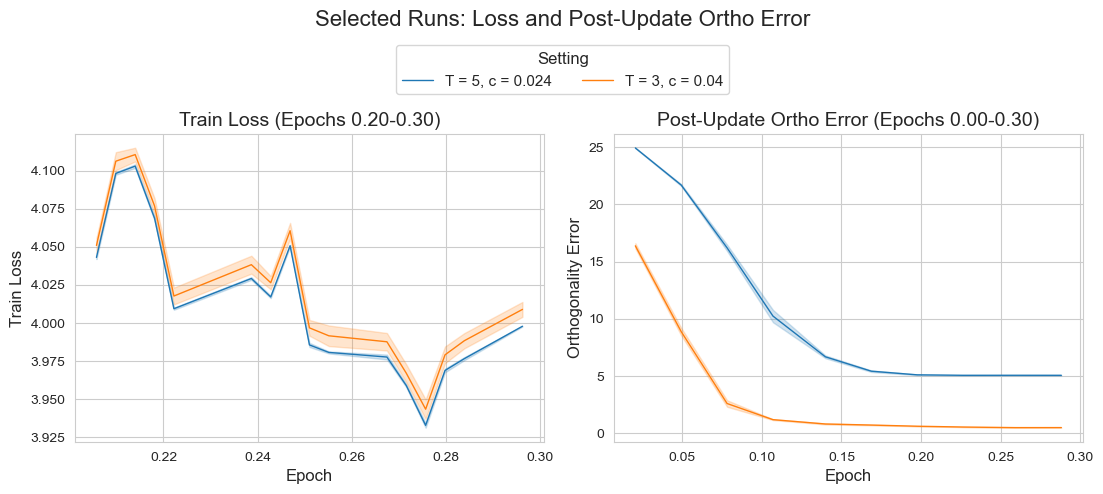

In [17]:
plot_loss_and_ortho_selected(df, x="step_norm", start_left=0.2, start_right=0, log_scale=False, save_plot=True)

In [706]:
def plot_data_filtered(
    df,
    x,
    y_list,
    title_list,
    filters,            # NEW: list of dicts defining each subplot's filter
    start=0,
    end=1000,
    use_ci=False,
    log_scale=False,
    plot_med=True,
    save_plot=False,
):

    assert len(filters) == len(y_list) == len(title_list), \
        "filters, y_list, and title_list must have the same length"

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4), sharey=False)

    for plt_idx, (y, flt) in enumerate(zip(y_list, filters)):

        # Apply filter (e.g., num_iters=3 & cushion=0.04)
        df_sub = df.copy()
        for key, val in flt.items():
            df_sub = df_sub[df_sub[key] == val]

        # Clip by step range
        df_clipped = df_sub[(start <= df_sub[x]) & (df_sub[x] <= end)]

        print(f"Plotting {title_list[plt_idx]} with filter:", flt)
        sns.set_style("whitegrid")

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y,
            errorbar="sd",
            linestyle="-",
            linewidth=1,
            alpha=1,
            ax=axes[plt_idx],
        )

        if log_scale:
            axes[plt_idx].set_yscale("log")

        axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
        axes[plt_idx].set_xlabel("Epoch", fontsize=12)
        axes[plt_idx].set_ylabel("Orthogonality Error", fontsize=12)

    fig.suptitle("Selected Runs: Orthogonality Error", y=1.15, fontsize=16)

    # unify y-limits
    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)
    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)

    fig.subplots_adjust(wspace=0.3)

    if save_plot:
        plt.savefig("./plots/cushion_ortho_selected.jpg", bbox_inches='tight')

    plt.show()

Plotting Num Iters = 3, Cushion = 0.04 with filter: {'config_optimizer_params.args.polar_num_iters': '[3]', 'config_optimizer_params.args.polar_cushion': 0.04}
Plotting Num Iters = 5, Cushion = 0.024 with filter: {'config_optimizer_params.args.polar_num_iters': '[5]', 'config_optimizer_params.args.polar_cushion': 0.024}


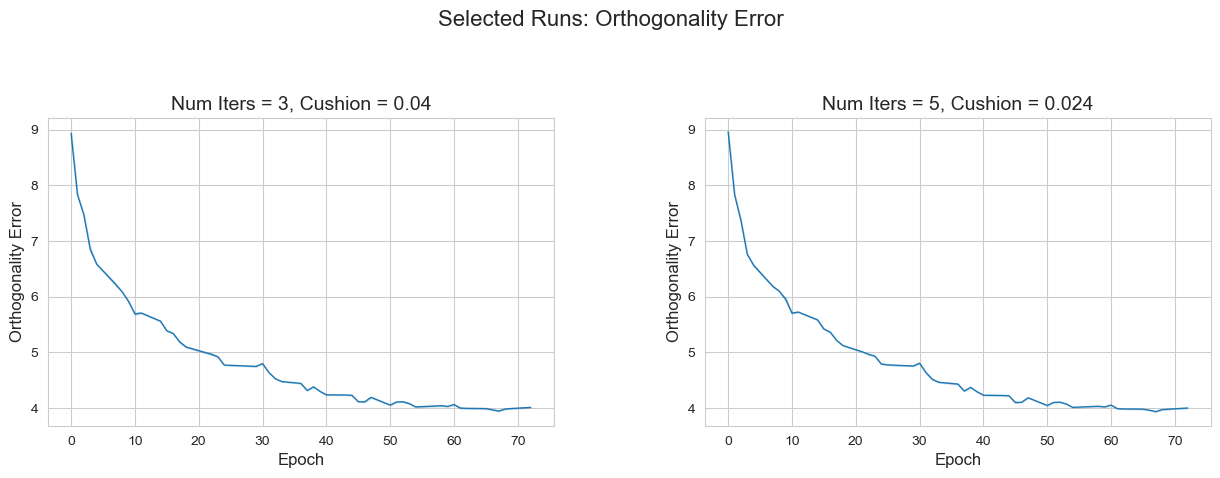

In [709]:
plot_data_filtered(
    df=df,
    x="_step",
    y_list=[
        "train/loss",
        "train/loss",
    ],   # same metric for both subplots
    title_list=[
        "Num Iters = 3, Cushion = 0.04",
        "Num Iters = 5, Cushion = 0.024",
    ],
    filters=[
        {"config_optimizer_params.args.polar_num_iters": "[3]", "config_optimizer_params.args.polar_cushion": 0.04},
        {"config_optimizer_params.args.polar_num_iters": "[5]", "config_optimizer_params.args.polar_cushion": 0.024},
    ],
    log_scale=False,
    save_plot=False
)

In [849]:
import ast
import numpy as np
import matplotlib.pyplot as plt

def plot_svd_specific_configs(
    df,
    svd_col,
    num_iters_col,
    cushion_col,
    step_col="step_norm",
    left_config=("[5]", 0.024),
    right_config=("[3]", 0.04),
    title_left="T = 5, c = 0.024",
    title_right="T = 3, c = 0.04",
    log_density=False,
    figsize=(14, 4),
    save_plot=False
):
    df_sorted = df.sort_values(step_col).reset_index(drop=True)

    panels = [
        (*left_config, title_left),
        (*right_config, title_right),
    ]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Load binning info from first non-null SVD entry
    first_series = df_sorted[svd_col].dropna()
    if first_series.empty:
        raise ValueError(f"No non-null data in {svd_col}")

    first_hist = ast.literal_eval(first_series.iloc[0])
    bins_info = first_hist["packedBins"]

    n_bins = bins_info["count"]
    bin_min = bins_info["min"]
    bin_size = bins_info["size"]
    bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

    # PRINT singular-value range
    global_min_sv = float(bin_centers.min())
    global_max_sv = float(bin_centers.max())
    print(f"Singular Value Range Across Histogram:")
    print(f"  min singular value = {global_min_sv}")
    print(f"  max singular value = {global_max_sv}")

    all_steps = df_sorted[step_col].dropna().to_numpy()
    x_min, x_max = all_steps.min(), all_steps.max()

    cmap = plt.cm.Blues
    cmap = cmap.copy()
    cmap.set_under("white")

    im = None

    # Track density min/max
    global_min_density = float("inf")
    global_max_density = float("-inf")

    for ax, (num_val, cushion_val, title) in zip(axes, panels):

        df_sel = df_sorted[
            (df_sorted[num_iters_col] == num_val) &
            (df_sorted[cushion_col] == cushion_val)
        ]

        valid_rows = df_sel[df_sel[svd_col].notna()]

        if valid_rows.empty:
            ax.set_title(title + " (no SVD data)")
            ax.set_xlabel("Epoch")
            continue

        steps = valid_rows[step_col].to_numpy()
        H = np.zeros((len(steps), n_bins), dtype=float)

        for i, s in enumerate(valid_rows[svd_col]):
            h = ast.literal_eval(s)
            vals = np.array(h["values"], dtype=float)

            if len(vals) > n_bins:
                vals = vals[:n_bins]
            elif len(vals) < n_bins:
                vals = np.pad(vals, (0, n_bins - len(vals)))

            H[i] = vals

        # Convert to density
        row_sum = H.sum(axis=1, keepdims=True)
        H = H / np.maximum(row_sum, 1e-12)

        # Track density range
        nz_vals = H[H > 0]
        if nz_vals.size > 0:
            global_min_density = min(global_min_density, nz_vals.min())
            global_max_density = max(global_max_density, nz_vals.max())

        H_plot = np.log1p(H) if log_density else H

        im = ax.imshow(
            H_plot.T,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, bin_centers.min(), bin_centers.max()],
            cmap=cmap,
            vmin=1e-12,
        )

        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel("Singular Value (Log Scale)", fontsize=12)
        ax.tick_params(axis='both', labelsize=10)

    # PRINT density range
    print(f"\nDensity Range Across Both Panels:")
    print(f"  min non-zero density = {global_min_density}")
    print(f"  max density = {global_max_density}")

    fig.suptitle("Singular Value Density for Selected (T, c)",
                 x=0.45, y=1.07, fontsize=16)

    axes[1].tick_params(labelleft=True, left=True)
    axes[1].set_ylabel("Singular Value (Log Scale)", fontsize=12)

    if im is not None:
        cbar = fig.colorbar(im, ax=axes, shrink=0.9)
        cbar.set_label("log(1 + density)" if log_density else "Density", fontsize=11)

    if save_plot:
        plt.savefig("./plots/svd_specific_configs_density.jpg", bbox_inches="tight")

    plt.show()

Singular Value Range Across Histogram:
  min singular value = -1.6625670165526572
  max singular value = -0.012203443038288242

Density Range Across Both Panels:
  min non-zero density = 0.0013020833333333333
  max density = 0.8815104166666666


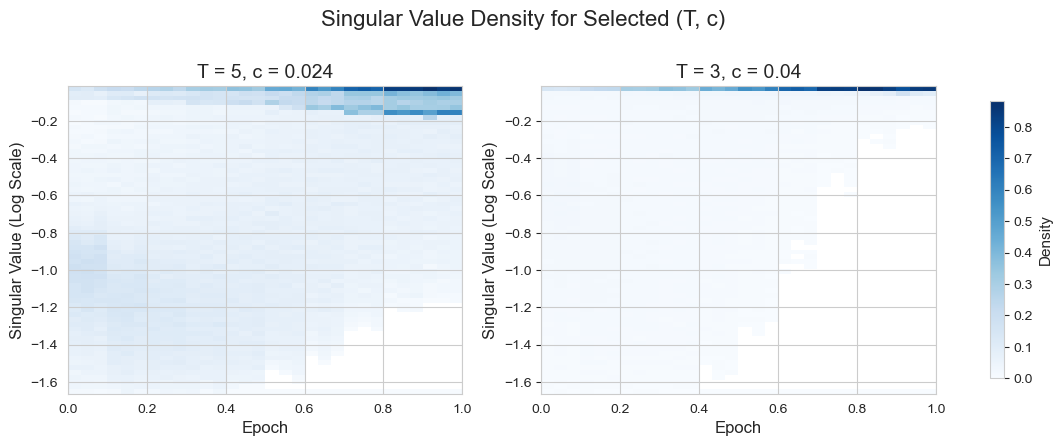

In [850]:
plot_svd_specific_configs(
    df,
    svd_col="svd_log/post_update/layer11/stacked",
    num_iters_col="config_optimizer_params.args.polar_num_iters",
    cushion_col="config_optimizer_params.args.polar_cushion",
    save_plot=False
)

In [32]:
df = load_sweep_data("j7qzf95f", manifest)
df["step_norm"] = df["_step"] / 243
for val in df['config_optimizer_params.args.polar_cushion'].unique():
    print(val)
for col in df.columns:
    print(col)
# x = 'diag_log_step'
# y = 'svd/layer11_q/condition_number'
# x_cols = df.columns.str.contains(x)
# print("Found x Columns:")
# for col in df.columns[x_cols]:
#     print("\t", col)

# y_cols = df.columns.str.contains(y)
# print("Found y Columns:")
# for col in df.columns[y_cols]:
#     print("\t", col)

# assert sum(x_cols) == 1, "invalid number of columns found for x"
# assert sum(y_cols) == 1, "invalid number of columns found for y"

Loading data for Sweep j7qzf95f...
Loaded 11468 rows. Columns: 187
0.024
svd_log/pre_update/layer11/stacked
qkv/layer0/k_norm/mean
logits/layer11/std
svd/pre_update/layer0/stacked
ortho/layer5_q/err
logits/layer11/max_p95
train/tokens_per_sec
ortho/layer11_q/err_normalized
svd/post_update/layer5/stacked
qkv/layer5/k_norm/mean
_runtime
qkv/layer5/q_norm/mean
svd/weights/layer5/stacked
attn/layer11/entropy/mean
svd_log/post_update/layer5/k
ortho/layer0_k/err
svd_log/pre_update/layer5/stacked
attn/layer11/entropy/p05
attn/layer11/entropy/p95
svd/post_update/layer11/q
qkv/layer5/v_norm/mean
svd_log/post_update/layer11/v
pe/ortho_err_after
ortho/layer11_k/err_normalized
qkv/layer0/v_norm/mean
val/ppl
train/total_time_seconds
svd/post_update/layer0/v
svd_log/post_update/layer5/q
svd/total_time_ms
logits/layer5/mean
ortho/layer0_q/err
svd/pre_update/layer11/v
svd/weights/layer5/v
attn/layer0/entropy/mean
val/loss
pe/ortho_err_before
ortho/layer0_v/err_normalized
svd_log/pre_update/layer11/q
l

In [502]:
def plot_data(df, x, y_list, title_list, hue, start=0, end=1000, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4))
    
    for plt_idx, y in enumerate(y_list):
        
        if x != "_step":
            x_cols = df.columns.str.contains(x)
            print("Found x Columns:")
            for col in df.columns[x_cols]:
                print(col)
            assert sum(x_cols) == 1, "invalid number of columns found for x"
        
        y_cols = df.columns.str.contains(y)
        print("Found y Columns:")
        for col in df.columns[y_cols]:
            print(col)
        assert sum(y_cols) == 1, "invalid number of columns found for y"

        ylabels = ["Train Loss", "Val Loss"]
        
        print("Plotting Data...")
        sns.set_style("whitegrid")
        hue_list = ["[3]", "[4]", "[5]", "[6]", "[7]",]
        for val in hue_list:
            df_grouped = df[df[hue] == val]
            df_clipped = df_grouped[(start <= df_grouped[x]) & (df_grouped[x] <= end)]
            ax_i = sns.lineplot(
                data=df_clipped,
                x=x,
                y=y,
                errorbar="sd",
                linestyle="-",
                linewidth=1,
                alpha=1,
                ax=axes[plt_idx],
                label=val.replace("[", "").replace("]", "") if plt_idx == 0 else None
            )
    
            if log_scale:
                axes[plt_idx].set_yscale("log")

            # axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
            axes[plt_idx].set_xlabel("Epoch", fontsize=12)
            axes[plt_idx].set_ylabel(f"{ylabels[plt_idx]}", fontsize=12)
    
    fig.suptitle("Num Iters: Loss (Epoch 0.95-1.00)", y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    leg = fig.legend(
        handles,
        labels,
        title="Num Iters",
        loc="upper center",
        ncol=5,
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)

    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)
        if ax.get_legend() is not None:
            ax.legend_.remove()
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/num_iters_loss.jpg", bbox_inches='tight')
    
    plt.show();

Found x Columns:
step_norm
Found y Columns:
train/loss
Plotting Data...
Found x Columns:
step_norm
Found y Columns:
val/loss
Plotting Data...
Plot Saved.


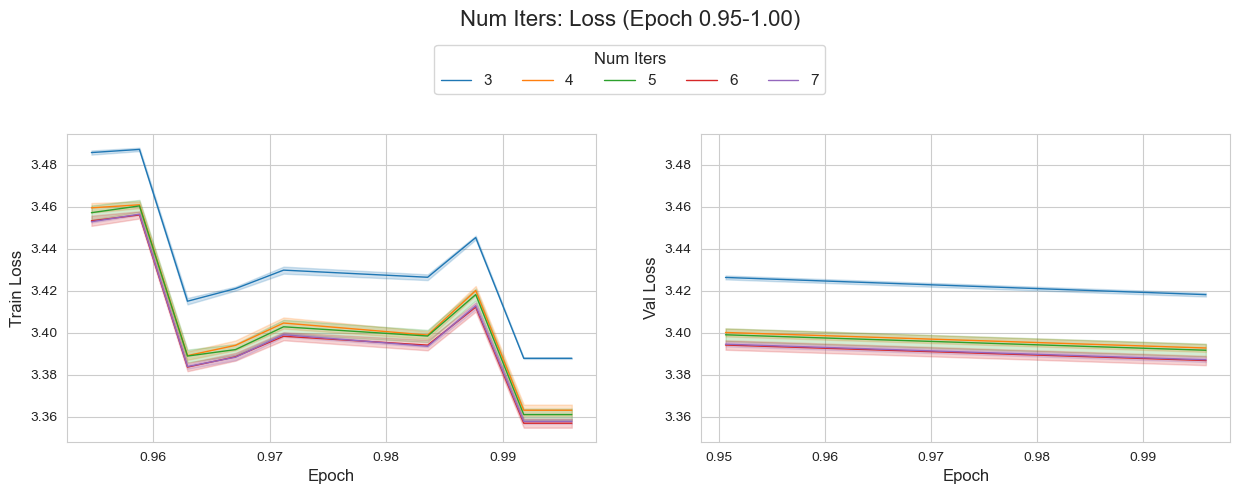

In [503]:
plot_data(
    df,
    x="step_norm",
    y_list=[
        "train/loss",
        "val/loss",
    ],
    title_list=[
        "Training Loss",
        "Validation Loss",
    ],
    hue="config_optimizer_params.args.polar_num_iters",
    start=0.95,
    log_scale=False,
    save_plot=True,
)

In [630]:
import ast
import numpy as np
import matplotlib.pyplot as plt

def plot_svd_cushion_heatmaps(
    df,
    svd_col,                 # e.g. 'svd_log/post_update/layer11/k'
    cushion_col,             # e.g. 'config/cushion'
    step_col="step_norm",
    cushion_vals=None,
    title_list=None,
    log_counts=False,
    figsize=(15, 4),
    save_plot=False,
):
    # Sort once
    df_sorted = df.sort_values(step_col).reset_index(drop=True)

    # Which cushions to plot
    if cushion_vals is None:
        cushion_vals = sorted(df_sorted[cushion_col].dropna().unique())

    n_panels = len(cushion_vals)

    if title_list is None:
        title_list = [f"{cushion_col} = {val}" for val in cushion_vals]

    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True)
    if n_panels == 1:
        axes = [axes]

    # Set up colormap: white for zero, dark blue for high density
    cmap = plt.cm.Blues
    cmap = cmap.copy()
    cmap.set_under("white")

    # Get binning from first non-null SVD entry
    first_series = df_sorted[svd_col].dropna()
    if first_series.empty:
        raise ValueError(f"No non-null data in {svd_col}")
    first_hist = ast.literal_eval(first_series.iloc[0])
    bins_info = first_hist["packedBins"]

    n_bins = bins_info["count"]
    bin_min = bins_info["min"]
    bin_size = bins_info["size"]
    bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

    # Global x-extent for all panels
    all_steps = df_sorted[step_col].dropna().to_numpy()
    x_min, x_max = all_steps.min(), all_steps.max()

    im = None

    for ax, cushion, title in zip(axes, cushion_vals, title_list):
        # Filter by cushion
        df_c = df_sorted[df_sorted[cushion_col] == cushion]

        # Keep only rows where SVD is logged
        valid_rows = df_c[df_c[svd_col].notna()]

        if valid_rows.empty:
            ax.set_title(title + " (no SVD data)")
            ax.set_xlabel("Step")
            continue

        steps = valid_rows[step_col].to_numpy()

        # Build [num_steps, num_bins] matrix of counts
        H = np.zeros((len(valid_rows), n_bins), dtype=float)
        for i, s in enumerate(valid_rows[svd_col]):
            h = ast.literal_eval(s)
            vals = np.array(h["values"], dtype=float)

            # Defensive padding/truncation
            if len(vals) > n_bins:
                vals = vals[:n_bins]
            elif len(vals) < n_bins:
                vals = np.pad(vals, (0, n_bins - len(vals)))

            H[i] = vals

        H_plot = np.log1p(H) if log_counts else H

        im = ax.imshow(
            H_plot.T,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, bin_centers.min(), bin_centers.max()],
            cmap=cmap,
            vmin=1e-12,
        )

        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Epoch", fontsize=11)
        ax.set_ylabel("Singular Value (Log Scale)", fontsize=11)
        ax.tick_params(axis='y', labelleft=True)

    fig.suptitle("Num Iters: Singular Value Distribution", x=0.45, y=1.05, fontsize=16)

    # Shared colorbar
    if im is not None:
        cbar = fig.colorbar(im, ax=axes, shrink=0.9)
        cbar.set_label("Count (Log Scale)" if log_counts else "Count", fontsize=11)

    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/num_iters_svd.jpg", bbox_inches='tight')

    plt.show()

Plot Saved.


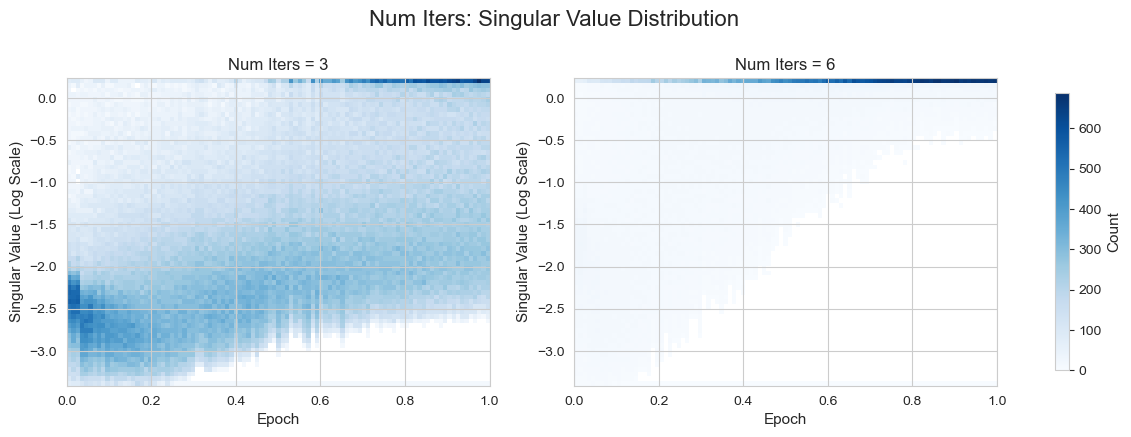

In [632]:
plot_svd_cushion_heatmaps(
    df,
    svd_col="svd_log/post_update/layer11/stacked",
    cushion_col="config_optimizer_params.args.polar_num_iters",
    cushion_vals=["[3]", "[6]"],
    title_list=["Num Iters = 3", "Num Iters = 6"],
    log_counts=False,   # or True if you prefer
    figsize=(15, 4),
    save_plot=True,
)

In [35]:
import ast
import numpy as np
import matplotlib.pyplot as plt

def plot_svd_cushion_heatmaps(
    df,
    svd_col_top,             # e.g. 'svd_log/pre_update/layer11/k'
    svd_col_bottom,          # e.g. 'svd_log/post_update/layer11/k'
    cushion_col,             # e.g. 'config/cushion'
    step_col="step_norm",
    cushion_vals=None,
    title_list=None,
    log_counts=False,        # if True: log(1 + value) for color
    use_density=False,       # if True, normalize each row to sum to 1
    figsize=(12, 10),
    save_plot=False,
):
    # Sort once
    df_sorted = df.sort_values(step_col).reset_index(drop=True)

    # Which cushions to plot
    if cushion_vals is None:
        cushion_vals = sorted(df_sorted[cushion_col].dropna().unique())

    if len(cushion_vals) != 2:
        raise ValueError(
            f"This function expects exactly two cushion values for a 2x2 grid; got {len(cushion_vals)}."
        )

    n_cols = 2

    if title_list is None:
        title_list = [f"{cushion_col} = {val}" for val in cushion_vals]

    fig, axes = plt.subplots(
        2, n_cols, figsize=figsize, sharex=True, sharey=True
    )

    from matplotlib.colors import LinearSegmentedColormap

    # Custom colormap: white → blue → purple → red
    cmap = LinearSegmentedColormap.from_list(
        "white_blue_purple_red",
        [
            (0.00, "white"),
            (0.20, "blue"),
            (0.60, "purple"),
            (1.00, "red"),
        ]
    )
    cmap = cmap.copy()
    cmap.set_under("white")

    # Get binning from first non-null SVD entry in the top column
    first_series = df_sorted[svd_col_top].dropna()
    if first_series.empty:
        raise ValueError(f"No non-null data in {svd_col_top}")
    first_hist = ast.literal_eval(first_series.iloc[0])
    bins_info = first_hist["packedBins"]

    n_bins = bins_info["count"]
    bin_min = bins_info["min"]
    bin_size = bins_info["size"]
    bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

    # Print singular value range
    sv_min = float(bin_centers.min())
    sv_max = float(bin_centers.max())
    print("Singular value range from histogram bins:")
    print(f"  min singular value = {sv_min}")
    print(f"  max singular value = {sv_max}")

    # Global x-extent for all panels
    all_steps = df_sorted[step_col].dropna().to_numpy()
    x_min, x_max = all_steps.min(), all_steps.max()

    ims_top = []
    ims_bottom = []

    # Track global min/max (count or density) over all four panels
    global_min_val = float("inf")
    global_max_val = float("-inf")

    def plot_one_row(ax_row, svd_col, row_idx, im_list):
        nonlocal global_min_val, global_max_val

        for col_idx, (ax, cushion, title) in enumerate(zip(ax_row, cushion_vals, title_list)):
            # Filter by cushion
            df_c = df_sorted[df_sorted[cushion_col] == cushion]

            # Keep only rows where SVD is logged
            valid_rows = df_c[df_c[svd_col].notna()]

            if valid_rows.empty:
                ax.set_title(title + " (no SVD data)")
                if row_idx == 1:
                    ax.set_xlabel("Epoch", fontsize=11)
                if col_idx == 0:
                    ax.set_ylabel("Singular Value (Log Scale)", fontsize=11)
                continue

            steps = valid_rows[step_col].to_numpy()

            # Build [num_steps, num_bins] matrix
            H = np.zeros((len(valid_rows), n_bins), dtype=float)
            for i, s in enumerate(valid_rows[svd_col]):
                h = ast.literal_eval(s)
                vals = np.array(h["values"], dtype=float)

                # Defensive padding/truncation
                if len(vals) > n_bins:
                    vals = vals[:n_bins]
                elif len(vals) < n_bins:
                    vals = np.pad(vals, (0, n_bins - len(vals)))

                H[i] = vals

            # Convert to density if requested
            if use_density:
                row_sum = H.sum(axis=1, keepdims=True)
                H = H / np.maximum(row_sum, 1e-12)

            # Track global min/max of non-zero values (counts or densities)
            nz_vals = H[H > 0]
            if nz_vals.size > 0:
                global_min_val = min(global_min_val, nz_vals.min())
                global_max_val = max(global_max_val, nz_vals.max())

            H_plot = np.log1p(H) if log_counts else H

            im = ax.imshow(
                H_plot.T,
                origin="lower",
                aspect="auto",
                extent=[x_min, x_max, bin_centers.min(), bin_centers.max()],
                cmap=cmap,
                vmin=1e-12,
            )
            im_list.append(im)

            if row_idx == 0:
                ax.set_title(f"{title}", fontsize=12)

            # X-label only on bottom row
            if row_idx == 1:
                ax.set_xlabel("Epoch", fontsize=11)

            # Y-label only on left column
            if col_idx == 0:
                if row_idx == 0:
                    ax.set_ylabel("Pre-Update\nSingular Value (Log Scale)", fontsize=11)
                else:
                    ax.set_ylabel("Post-Update\nSingular Value (Log Scale)", fontsize=11)

            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)

    # Top row: svd_col_top
    plot_one_row(axes[0, :], svd_col_top, row_idx=0, im_list=ims_top)
    # Bottom row: svd_col_bottom
    plot_one_row(axes[1, :], svd_col_bottom, row_idx=1, im_list=ims_bottom)

    # Print value range (density or count)
    if use_density:
        print("\nDensity range across all panels (non-zero bins):")
    else:
        print("\nCount range across all panels (non-zero bins):")
    print(f"  min value = {global_min_val}")
    print(f"  max value = {global_max_val}")

    # Layout before colorbars
    fig.tight_layout(rect=[0, 0, 1, 0.93])

    # Decide colorbar label based on mode
    if use_density:
        cbar_label = "Density (Log Scale)" if log_counts else "Density"
    else:
        cbar_label = "Count (Log Scale)" if log_counts else "Count"

    # Normalize and add separate colorbars for each row
    if ims_top:
        vmax_top = max(im.get_array().max() for im in ims_top)
        for im in ims_top:
            im.set_clim(vmin=1e-12, vmax=vmax_top)
        cbar_top = fig.colorbar(ims_top[-1], ax=axes[0, :], shrink=0.9)
        cbar_top.set_label(cbar_label, fontsize=11)

    if ims_bottom:
        vmax_bot = max(im.get_array().max() for im in ims_bottom)
        for im in ims_bottom:
            im.set_clim(vmin=1e-12, vmax=vmax_bot)
        cbar_bot = fig.colorbar(ims_bottom[-1], ax=axes[1, :], shrink=0.9)
        cbar_bot.set_label(cbar_label, fontsize=11)

    fig.suptitle(
        "Num Iters: Singular Value " + ("Density" if use_density else "Distribution"),
        x=0.45,
        y=0.96,
        fontsize=16,
    )

    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/num_iters_svd.jpg", bbox_inches='tight')

    plt.show()

Singular value range from histogram bins:
  min singular value = 0.014927266955510277
  max singular value = 1.850437593263905

Density range across all panels (non-zero bins):
  min value = 0.0013020833333333333
  max value = 0.8880208333333334


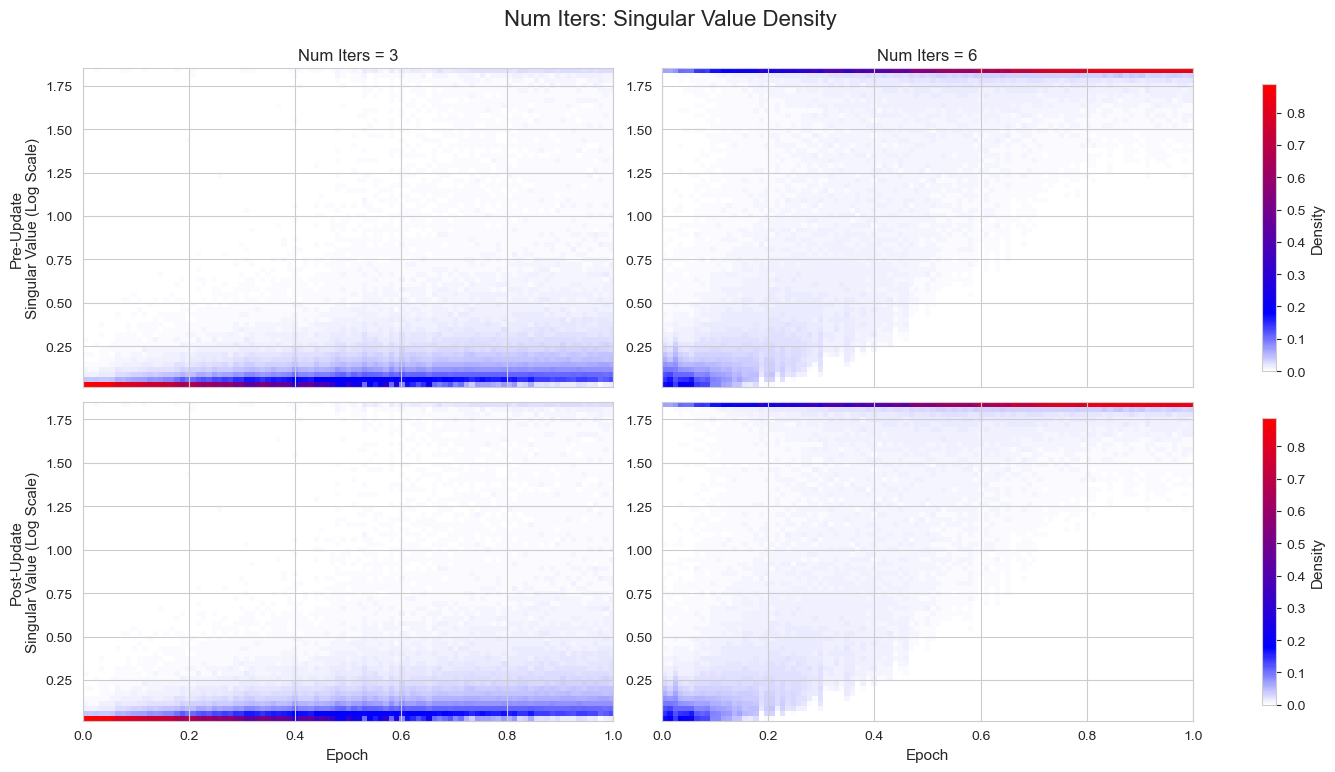

In [36]:
plot_svd_cushion_heatmaps(
    df,
    svd_col_top="svd/post_update/layer11/stacked",
    svd_col_bottom="svd/post_update/layer11/stacked",
    cushion_col="config_optimizer_params.args.polar_num_iters",  # grouping key
    cushion_vals=["[3]", "[6]"],                                 # 3 vs 6 iters
    title_list=["Num Iters = 3", "Num Iters = 6"],
    log_counts=False,     # or True for log(1 + density)
    use_density=True,     # <<< this is the new part
    figsize=(15, 8),
    save_plot=False,
)

In [33]:
import ast
import numpy as np
import matplotlib.pyplot as plt

def plot_svd_cushion_heatmaps(
    df,
    svd_col_top,
    cushion_col,
    step_col="step_norm",
    cushion_vals=None,
    title_list=None,
    log_counts=False,
    use_density=False,
    figsize=(15, 4),
    save_plot=False,
):
    df_sorted = df.sort_values(step_col).reset_index(drop=True)

    if cushion_vals is None:
        cushion_vals = sorted(df_sorted[cushion_col].dropna().unique())

    if len(cushion_vals) != 2:
        raise ValueError("Exactly two cushion values required.")

    n_cols = 2

    if title_list is None:
        title_list = [f"{cushion_col} = {val}" for val in cushion_vals]

    fig, axes = plt.subplots(
        1, n_cols, figsize=figsize, sharex=True, sharey=False
    )

    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list(
        "white_blue_purple_red",
        [
            (0.00, "white"),
            (0.20, "blue"),
            (0.60, "purple"),
            (1.00, "red"),
        ]
    )
    cmap = cmap.copy()
    cmap.set_under("white")

    # Extract binning
    first_hist = ast.literal_eval(df_sorted[svd_col_top].dropna().iloc[0])
    bins_info = first_hist["packedBins"]
    n_bins = bins_info["count"]
    bin_min = bins_info["min"]
    bin_size = bins_info["size"]
    bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

    # x extent
    all_steps = df_sorted[step_col].dropna().to_numpy()
    x_min, x_max = all_steps.min(), all_steps.max()

    ims_top = []
    global_min_val = float("inf")
    global_max_val = float("-inf")

    def plot_one_row(ax_row, svd_col, im_list):
        nonlocal global_min_val, global_max_val

        for col_idx, (ax, cushion, title) in enumerate(
            zip(ax_row, cushion_vals, title_list)
        ):
            df_c = df_sorted[df_sorted[cushion_col] == cushion]
            valid_rows = df_c[df_c[svd_col].notna()]

            if valid_rows.empty:
                ax.set_title(title + " (no SVD data)")
                ax.set_ylabel("Singular Value (Log Scale)", fontsize=11)
                ax.set_xlabel("Epoch", fontsize=11)
                continue

            steps = valid_rows[step_col].to_numpy()

            H = np.zeros((len(valid_rows), n_bins))
            for i, s in enumerate(valid_rows[svd_col]):
                vals = np.array(ast.literal_eval(s)["values"], dtype=float)
                if len(vals) > n_bins:
                    vals = vals[:n_bins]
                elif len(vals) < n_bins:
                    vals = np.pad(vals, (0, n_bins - len(vals)))
                H[i] = vals

            if use_density:
                row_sum = H.sum(axis=1, keepdims=True)
                H = H / np.maximum(row_sum, 1e-12)

            nz = H[H > 0]
            if nz.size > 0:
                global_min_val = min(global_min_val, nz.min())
                global_max_val = max(global_max_val, nz.max())

            H_plot = np.log1p(H) if log_counts else H

            im = ax.imshow(
                H_plot.T,
                origin="lower",
                aspect="auto",
                extent=[x_min, x_max, bin_centers.min(), bin_centers.max()],
                cmap=cmap,
                vmin=1e-12,
            )
            im_list.append(im)

            ax.set_title(title, fontsize=12)
            ax.set_xlabel("Epoch", fontsize=11)
            if col_idx == 0:
                ax.set_ylabel("Singular Value (Log Scale)", fontsize=11)

    # Plot only the top row
    plot_one_row(axes, svd_col_top, ims_top)

    # Colorbar
    cbar_label = (
        ("Density (Log Scale)" if log_counts else "Density")
        if use_density else
        ("Count (Log Scale)" if log_counts else "Count")
    )

    if ims_top:
        vmax_top = max(im.get_array().max() for im in ims_top)
        for im in ims_top:
            im.set_clim(vmin=1e-12, vmax=vmax_top)
        cbar_top = fig.colorbar(ims_top[-1], ax=axes, shrink=0.9)
        cbar_top.set_label(cbar_label, fontsize=11)

    fig.suptitle(
        "Num Iters: Post-Update Singular Value " + ("Density" if use_density else "Distribution"),
        x=0.45,
        y=1.02,
        fontsize=16,
    )

    if save_plot:
        plt.savefig("./plots/num_iters_svd_pre_3_4.jpg", bbox_inches="tight")

    plt.show()

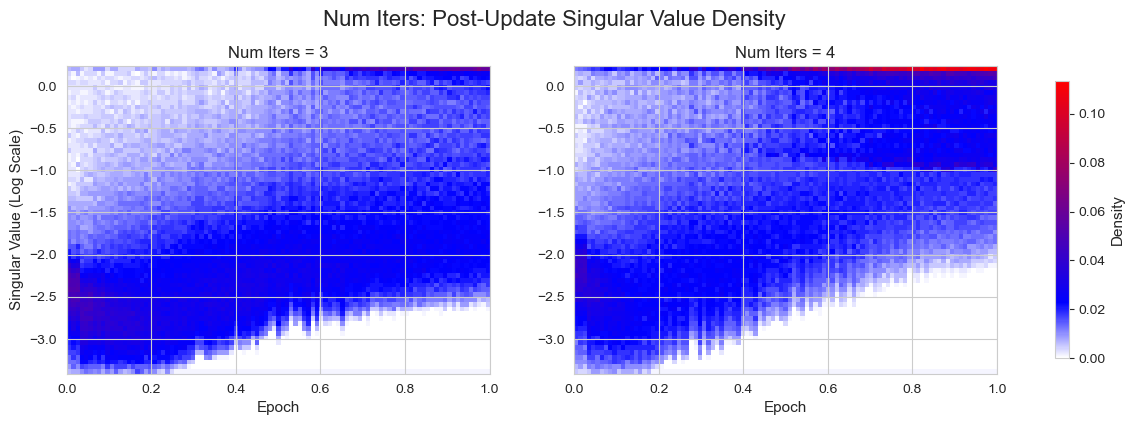

In [34]:
plot_svd_cushion_heatmaps(
    df,
    svd_col_top="svd_log/post_update/layer11/stacked",
    # svd_col_bottom="svd_log/post_update/layer11/stacked",
    cushion_col="config_optimizer_params.args.polar_num_iters",  # grouping key
    cushion_vals=["[3]", "[4]"],                                 # 3 vs 6 iters
    title_list=["Num Iters = 3", "Num Iters = 4"],
    log_counts=False,     # or True for log(1 + density)
    use_density=True,     # <<< this is the new part
    figsize=(15, 4),
    save_plot=True,
)

In [52]:
df_sorted = df.sort_values("_step").reset_index(drop=True)

first_series = df_sorted["svd/post_update/layer11/stacked"].dropna()
if first_series.empty:
    raise ValueError(f"No non-null data in {svd_col_top}")
first_hist = ast.literal_eval(first_series.iloc[0])
bins_info = first_hist["packedBins"]

n_bins = bins_info["count"]
bin_min = bins_info["min"]
bin_size = bins_info["size"]
bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

first_hist

{'packedBins': {'min': 0.0003597246832214296,
  'size': 0.029135084544577694,
  'count': 64},
 '_type': 'histogram',
 'values': [689,
  36,
  8,
  2,
  3,
  1,
  3,
  2,
  0,
  2,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  1,
  0,
  2,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  4]}